In [1]:
#R histograms up to wall with exponential fit. Ensure to ignore bins with n<10

#OBJECTIVE 1: Fit emperical function to wall output
#OBJ 2: Extrapolate to detector fiducial

In [2]:
#INITIALIZION
#Kernel PyROOT
import os
#os.sys.path.append('/usr/common/software/rootpy')
#os.sys.path.insert(0,'/usr/common/software/uproot')
#import root_numpy
#import root_numpy as root_np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('GTK3Agg')
import ROOT
import pandas as pd
from scipy.optimize import curve_fit

import sys
from matplotlib.colors import LogNorm
import pylab

import glob
import uproot

import scipy
from scipy.optimize import curve_fit

%pylab inline
#pylab.rcParams['figure.figsize'] = (10.0, 8.0)

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

print("Starting notebook....")


Welcome to JupyROOT 6.16/00
Populating the interactive namespace from numpy and matplotlib
Starting notebook....


/cvmfs/sft.cern.ch/lcg/views/LCG_95/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


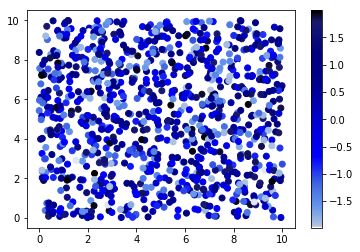

In [3]:
#Custom colormap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
#rvb = make_colormap(
#    [c('white'), c('violet'), 0.33, c('violet'), c('blue'), 0.66, c('blue'), c('black')])

PetersBlue = make_colormap(
    #[c('white'), c('red'), 0.5, c('red'), c('black')])
    #[c('white'), c('yellow'), 0.25, c('yellow'), c('orange'), 0.5, c('orange'), c('red'), 0.75, c('red'), c('black')])
    #[c('white'), c('salmon'), 0.3, c('salmon'), c('tomato'), 0.6, c('tomato'), c('red'), 0.9, c('red'), c('firebrick'), 0.95, c('firebrick'), c('black')])
    [c('white'), c('lightsteelblue'), 0.01, c('lightsteelblue'),  c('cornflowerblue'), 0.1, c('cornflowerblue'),c('royalblue'), 0.2, c('royalblue'), c('blue'), 0.33, c('blue'),  c('mediumblue'), 0.5, c('mediumblue'),  c('darkblue'), 0.66, c('darkblue'), c('navy'), 0.8, c('navy'), c('midnightblue'), 0.95, c('midnightblue'), c('black')])
#Test colormap
N = 1000
array_dg = np.random.uniform(0, 10, size=(N, 2))
colors = np.random.uniform(-2, 2, size=(N,))
plt.scatter(array_dg[:, 0], array_dg[:, 1], c=colors, cmap=PetersBlue)
plt.colorbar()
plt.show()

In [4]:
#Read input txt file
filename = "/home/rossiter/Xe131m_Generator/ReducedAnalysis/DaveTDR/Analysis/NEWXe131m_6.124e9_20171121_bg_analysis_tree.root"
filename_2 = "/home/rossiter/Xe131m_Generator/ReducedAnalysis/DaveTDR/ReducedAnalysisTree/NEWXe131m_1e7_20170814_reduced.root"
MDC2_DriftMap_filename="/data/rossiter/lz/XYZPositionCorrector/SimsMap_r1.1to72.8_z0.1to146_0218.txt"
print("...Done!")


...Done!


In [5]:
f=open(MDC2_DriftMap_filename, 'r')
lines=f.readlines()
print len(lines)

1057053


In [6]:
#Get MDC2 drift map
print len(lines)
print lines[0]
print lines[1]
print lines[2]
print lines[3].split(",\t\t")
print lines[4]
print lines[5]

rIN_cm_list =[]
zIN_cm_list =[]
rOUT_cm_list=[]
zOUT_cm_list=[]
DT_us_list = []

i=0
for line in lines:
    if i %1000000 ==0:
        print str(i)+" / "+str(len(lines))
    if line.startswith("#"):
        continue
    else:
        a=line.split(",\t\t")
        rIN_cm_list.append(float(a[0]))
        zIN_cm_list.append(float(a[1]))
        rOUT_cm_list.append(float(a[3]))
        zOUT_cm_list.append(float(a[4]))
        DT_us_list.append(float(a[2]))
        i+=1


print "\n\t ... Done!"

1057053
############################################################################## 

#rIN_cm		zIN_cm		DriftTime_us		rOUT_cm		z_OUT#

############################################################################## 

['0', '1.1', '877.376', '0', '146.1\n']
0,		1.2,		876.749,		0,		146.1

0,		1.3,		876.067,		0,		146.1

0 / 1057053
0 / 1057053
0 / 1057053
0 / 1057053
1000000 / 1057053

	 ... Done!


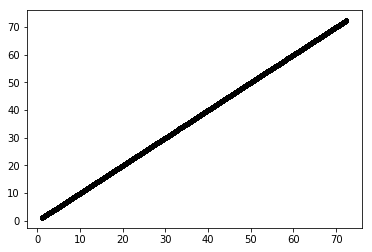

In [7]:
#Find formula to get DriftMap entry
r_m= 14500
z_m = 10
z_c = -11



#i=0
#print str(i)+"\t"+str(rIN_cm_list[i])+"\t"+str(zIN_cm_list[i])

#i=1449
#print str(i)+"\t"+str(rIN_cm_list[i])+"\t"+str(zIN_cm_list[i])
#print "\n"

"""
for r in range(0,5):
    for z in range(20,25):
        i = r_m*r + z_m*z+z_c
        print str(r)+"\t"+str(z)+"\t|\t"+str(rIN_cm_list[i])+"\t"+str(zIN_cm_list[i])

"""
temp_r_list =[]
other_temp_r_list=[]
temp_z_list =[]
other_temp_z_list=[]
for ii in range(11,725):
    for iii in range(0,1460):
        r=float(ii)/10
        z=float(iii)/10
        i=int(round(r_m*r) +round(z_m*z+z_c) )#1450
        #print str(i)+":\t"+str(r)+"\t"+str(rIN_cm_list[i])+"\t"+str(zIN_cm_list[i])
        temp_r_list.append(r)
        other_temp_r_list.append(rIN_cm_list[i])
        temp_z_list.append(z)
        other_temp_z_list.append(zIN_cm_list[i])

figure(1)
plt.plot(temp_r_list, other_temp_r_list, '.k')

In [8]:

r=72.7936
z=77.87165

i=int( (r_m*round(r*10)/10) +z_m*round(z)+z_c )#1450
print str(i)+":\t"+str(r)+"\t"+str(z)+"\t|\t"+str(rIN_cm_list[i])+"\t"+str(zIN_cm_list[i])

1056369:	72.7936	77.87165	|	72.8	78.0


In [9]:
print len(rIN_cm_list)
print max(rIN_cm_list)

1057050
72.8


In [10]:
def GetWeightedMean(inlist_1, inlist_2, lo_lim, hi_lim):
    numerator = 0
    denominator = 0
    #sum = 0
    for i in range(lo_lim, hi_lim):
        print str(inlist_1[i])+"\t"+str(inlist_2[i])
        numerator += inlist_1[i]*inlist_2[i]
        denominator += inlist_2[i]
    return numerator / denominator, denominator

In [99]:
#Initialize arrays, retrieve first MCtruth file

#root_file=DATApath+ROOTfiles[0]

def ReadDataFile(root_file):
    #list branches you want to retrive
    bg_analysis_RQs = ['fLXeR_cm', 'fLXeZ_cm', 'fLXeS1c_phe', 'fLXeS2c_phe', 'fPrimaryParX_cm', 'fPrimaryParY_cm', 'fPrimaryParZ_cm']

    #Open the trees from the root file
    bg_analysis_Vertices=uproot.open(root_file)['bg_analysis_tree']
    #bg_analysis_Vertices.show()

    #extract the branches in the list you want from those trees
    #it returns as dictionary with those variables in them
    bg_analysis_Vertices_data=bg_analysis_Vertices.arrays(bg_analysis_RQs)

    bg_analysis_fLXeR_cm= bg_analysis_Vertices_data['fLXeR_cm']
    bg_analysis_fLXeZ_cm= bg_analysis_Vertices_data['fLXeZ_cm']
    bg_analysis_fLXeS1c_phe= bg_analysis_Vertices_data['fLXeS1c_phe']
    bg_analysis_fLXeS2c_phe= bg_analysis_Vertices_data['fLXeS2c_phe']
    bg_analysis_fPrimaryParX_cm= bg_analysis_Vertices_data['fPrimaryParX_cm']
    bg_analysis_fPrimaryParY_cm= bg_analysis_Vertices_data['fPrimaryParY_cm']
    bg_analysis_fPrimaryParZ_cm= bg_analysis_Vertices_data['fPrimaryParZ_cm']

    bg_analysis_fPrimaryParR_cm = pow(pow(bg_analysis_fPrimaryParX_cm, 2)+pow(bg_analysis_fPrimaryParY_cm, 2), .5)
    
    return bg_analysis_fLXeR_cm, bg_analysis_fLXeZ_cm, bg_analysis_fLXeS1c_phe, bg_analysis_fLXeS2c_phe, bg_analysis_fPrimaryParR_cm, bg_analysis_fPrimaryParZ_cm


fLXeR_cm_list, fLXeZ_cm_list, fLXeS1c_phe_list, fLXeS2c_phe_list, bg_analysis_fPrimaryParR_cm_list, bg_analysis_fPrimaryParZ_cm_list =  ReadDataFile(filename)

print "min(fLXeR_cm_list): "+str(min(fLXeR_cm_list))
print "max(fLXeR_cm_list): "+str(max(fLXeR_cm_list))
print "len(fLXeR_cm_list): "+str(len(fLXeR_cm_list))

print "\nmin(fLXeZ_cm_list): "+str(min(fLXeZ_cm_list))
print "max(fLXeZ_cm_list): "+str(max(fLXeZ_cm_list))

print "\nmin(fLXeS1c_phe_list): "+str(min(fLXeS1c_phe_list))
print "max(fLXeS1c_phe_list): "+str(max(fLXeS1c_phe_list))

print "\nmin(fLXeS2c_phe_list): "+str(min(fLXeS2c_phe_list))
print "max(fLXeS2c_phe_list): "+str(max(fLXeS2c_phe_list))

print("\n\t...Done!")

min(fLXeR_cm_list): 0.11939433
max(fLXeR_cm_list): 72.8
len(fLXeR_cm_list): 357442

min(fLXeZ_cm_list): 0.000135095
max(fLXeZ_cm_list): 146.1

min(fLXeS1c_phe_list): 0.0
max(fLXeS1c_phe_list): 424.81912

min(fLXeS2c_phe_list): 0.0
max(fLXeS2c_phe_list): 304833.03

	...Done!


In [12]:
def ReadDataFile_2(root_file):
    #list branches you want to retrive
    bg_analysis_RQs = ['fLXeX_cm', 'fLXeY_cm', 'fLXeZ_cm', 'fLXe_tot_s1c', 'fLXe_tot_s2c', 
                       'fPrimaryParX_cm', 'fPrimaryParY_cm', 'fPrimaryParZ_cm']

    #Open the trees from the root file
    bg_analysis_Vertices=uproot.open(root_file)['lzsim_analysis_tree']
    #bg_analysis_Vertices.show()

    #extract the branches in the list you want from those trees
    #it returns as dictionary with those variables in them
    bg_analysis_Vertices_data=bg_analysis_Vertices.arrays(bg_analysis_RQs)

    bg_analysis_fLXeX_cm= bg_analysis_Vertices_data['fLXeX_cm']
    bg_analysis_fLXeY_cm= bg_analysis_Vertices_data['fLXeY_cm']
    bg_analysis_fLXeZ_cm= bg_analysis_Vertices_data['fLXeZ_cm']
    bg_analysis_fLXeS1c_phe= bg_analysis_Vertices_data['fLXe_tot_s1c']
    bg_analysis_fLXeS2c_phe= bg_analysis_Vertices_data['fLXe_tot_s2c']
    bg_analysis_fPrimaryParX_cm= bg_analysis_Vertices_data['fPrimaryParX_cm']
    bg_analysis_fPrimaryParY_cm= bg_analysis_Vertices_data['fPrimaryParY_cm']
    bg_analysis_fPrimaryParZ_cm= bg_analysis_Vertices_data['fPrimaryParZ_cm']

    bg_analysis_fLXeR_cm = pow( pow(bg_analysis_fLXeX_cm,2) + pow(bg_analysis_fLXeY_cm,2) ,.5)
    bg_analysis_fPrimaryParR_cm = pow( pow(bg_analysis_fPrimaryParX_cm,2) + pow(bg_analysis_fPrimaryParY_cm,2) ,.5)
    
    return bg_analysis_fLXeR_cm, bg_analysis_fLXeZ_cm, bg_analysis_fLXeS1c_phe, bg_analysis_fLXeS2c_phe, bg_analysis_fPrimaryParR_cm, bg_analysis_fPrimaryParZ_cm


print "reading file"
ALL_fLXeR_cm_temp_list, ALL_fLXeZ_cm_temp_list, ALL_fLXeS1c_phe_temp_list, ALL_fLXeS2c_phe_temp_list, ALL_bg_analysis_fPrimaryParR_cm_temp_list, ALL_bg_analysis_fPrimaryParZ_cm_temp_list =  ReadDataFile_2(filename_2)    

print "cleaning lists"

ALL_fLXeR_cm_list = []
ALL_fLXeZ_cm_list= []
ALL_fLXeS1c_phe_list= []
ALL_fLXeS2c_phe_list= []
ALL_fPrimaryParR_cm_list=[]
ALL_fPrimaryParZ_cm_list=[]

limit = len(ALL_fLXeR_cm_temp_list)
for i in range(0, limit):
    if i % 500000 ==0:
        print "\t"+str(i)+" / "+str(limit)
    if len(ALL_fLXeR_cm_temp_list[i]) == 1 and len(ALL_fLXeZ_cm_temp_list[i]) == 1 and len(ALL_fLXeS1c_phe_temp_list[i]) == 1 and len(ALL_fLXeS2c_phe_temp_list[i]) == 1:
        ALL_fLXeR_cm_list.append(ALL_fLXeR_cm_temp_list[i][0])
        ALL_fLXeZ_cm_list.append(ALL_fLXeZ_cm_temp_list[i][0])
        ALL_fLXeS1c_phe_list.append(ALL_fLXeS1c_phe_temp_list[i][0])
        ALL_fLXeS2c_phe_list.append(ALL_fLXeS2c_phe_temp_list[i][0])
        ALL_fPrimaryParR_cm_list.append(ALL_bg_analysis_fPrimaryParR_cm_temp_list[i][0])
        ALL_fPrimaryParZ_cm_list.append(ALL_bg_analysis_fPrimaryParZ_cm_temp_list[i][0])
print "min(ALL_fLXeR_cm_list): "+str(min(ALL_fLXeR_cm_list))
print "max(ALL_fLXeR_cm_list): "+str(max(ALL_fLXeR_cm_list))
print "len(ALL_fLXeR_cm_list): "+str(len(ALL_fLXeR_cm_list))

print "\nmin(ALL_fLXeZ_cm_list): "+str(min(ALL_fLXeZ_cm_list))
print "max(ALL_fLXeZ_cm_list): "+str(max(ALL_fLXeZ_cm_list))

print "\nmin(ALL_fLXeS1c_phe_list): "+str(min(ALL_fLXeS1c_phe_list))
print "max(ALL_fLXeS1c_phe_list): "+str(max(ALL_fLXeS1c_phe_list))

print "\nmin(ALL_fLXeS2c_phe_list): "+str(min(ALL_fLXeS2c_phe_list))
print "max(ALL_fLXeS2c_phe_list): "+str(max(ALL_fLXeS2c_phe_list))

print("\n\t...Done!")


reading file
cleaning lists
	0 / 4905519
	500000 / 4905519
	1000000 / 4905519
	1500000 / 4905519
	2000000 / 4905519
	2500000 / 4905519
	3000000 / 4905519
	3500000 / 4905519
	4000000 / 4905519
	4500000 / 4905519
min(ALL_fLXeR_cm_list): 0.018004753
max(ALL_fLXeR_cm_list): 72.799995
len(ALL_fLXeR_cm_list): 3270623

min(ALL_fLXeZ_cm_list): 3.255365e-06
max(ALL_fLXeZ_cm_list): 146.09998

min(ALL_fLXeS1c_phe_list): 0.0
max(ALL_fLXeS1c_phe_list): 698.7346

min(ALL_fLXeS2c_phe_list): 4002.1843
max(ALL_fLXeS2c_phe_list): 586331.7

	...Done!


In [13]:

print len(ALL_bg_analysis_fPrimaryParR_cm_temp_list)
print len(ALL_bg_analysis_fPrimaryParR_cm_temp_list[0])

for i in range(0, 20):
    print ALL_bg_analysis_fPrimaryParR_cm_temp_list[i]
#figure(1)
#plt.plot(ALL_bg_analysis_fPrimaryParR_cm_temp_list, ALL_bg_analysis_fPrimaryParZ_cm_temp_list, '.k')       


4905519
4
[80.4037 80.4037 80.4037 80.4037]
[58.90025 58.90025 58.90025]
[62.82587 62.82587 62.82587 62.82587]
[63.251938 63.251938 63.251938 63.251938 63.251938]
[42.310158 42.310158 42.310158 42.310158]
[68.25204 68.25204 68.25204]
[74.71271 74.71271 74.71271]
[8.486569 8.486569 8.486569]
[48.147125 48.147125 48.147125]
[82.02461 82.02461 82.02461 82.02461]
[55.48595 55.48595 55.48595]
[70.79852 70.79852 70.79852 70.79852]
[59.303474 59.303474 59.303474 59.303474]
[81.951225 81.951225 81.951225]
[62.40036 62.40036 62.40036]
[33.874077 33.874077 33.874077 33.874077]
[16.309687 16.309687]
[70.43485 70.43485]
[67.53233 67.53233 67.53233 67.53233]
[42.993618]


In [14]:

print len(ALL_fPrimaryParR_cm_list)
print len(ALL_fPrimaryParZ_cm_list)
print "\n"
#print len(ALL_fPrimaryParR_cm_list[0])

for i in range(0, 10):
    print str(ALL_fPrimaryParR_cm_list[i])+"\t"+str(ALL_fPrimaryParZ_cm_list[i])
    
    
#figure(1)
#plt.plot(ALL_fPrimaryParR_cm_list, ALL_fPrimaryParZ_cm_list, '.k')       


3270623
3270623


58.90025	125.36416
62.82587	3.4280422
63.251938	108.30042
42.310158	9.093259
8.486569	26.268387
48.147125	91.956184
55.48595	136.23073
70.79852	27.066298
59.303474	8.739853
33.874077	142.10332


min(ALL_fLXeR_cm_list): 0.018004753
max(ALL_fLXeR_cm_list): 72.799995

min(ALL_fLXeZ_cm_list): 3.255365e-06
max(ALL_fLXeZ_cm_list): 146.09998

min(ALL_fLXeS1c_phe_list): 0.0
max(ALL_fLXeS1c_phe_list): 698.7346


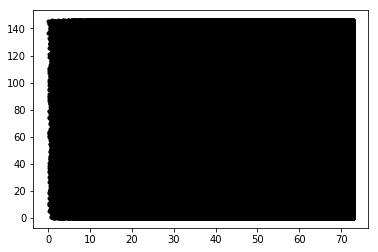

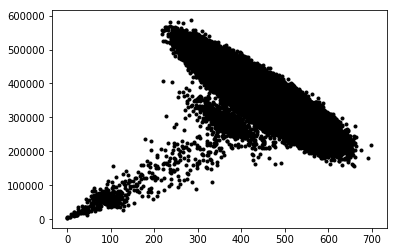

In [15]:

#Check
figure(1)
plt.plot(ALL_fLXeR_cm_list, ALL_fLXeZ_cm_list, '.k')


figure(2)
plt.plot(ALL_fLXeS1c_phe_list, ALL_fLXeS2c_phe_list, '.k')


print "min(ALL_fLXeR_cm_list): "+str(min(ALL_fLXeR_cm_list))
print "max(ALL_fLXeR_cm_list): "+str(max(ALL_fLXeR_cm_list))

print "\nmin(ALL_fLXeZ_cm_list): "+str(min(ALL_fLXeZ_cm_list))
print "max(ALL_fLXeZ_cm_list): "+str(max(ALL_fLXeZ_cm_list))

print "\nmin(ALL_fLXeS1c_phe_list): "+str(min(ALL_fLXeS1c_phe_list))
print "max(ALL_fLXeS1c_phe_list): "+str(max(ALL_fLXeS1c_phe_list))


len(fLXeR_cm_list): 357442

	0 / 357442
	100000 / 357442
	200000 / 357442
	300000 / 357442

len(Reduced_Z_list): 101464
min(Reduced_Z_list): 137.74496
max(Reduced_Z_list): 146.1

len(R_forRZplot_list): 48532
len(Z_forRZplot_list): 48532

	... Done!


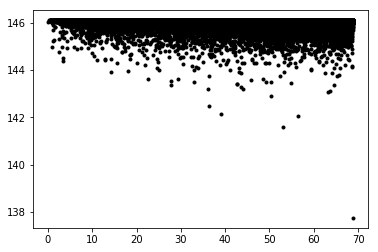

In [16]:
#FIRST CHECK Z RANGE
Reduced_Z_list = []
Reduced_R_list = []

R_forRZplot_list = []
Z_forRZplot_list = []
S1_forS1S2plot_list = []
S2_forS1S2plot_list = []

print("len(fLXeR_cm_list): "+str(len(fLXeR_cm_list))+"\n")
for i in range(0,len(fLXeR_cm_list)):
    if i %100000 == 0:
        print( "\t"+str(i)+" / "+str(len(fLXeR_cm_list)) )
    if fLXeZ_cm_list[i] < 1.45953906e2 and fLXeR_cm_list[i] < 72.7273224 and fLXeS1c_phe_list[i]> 0. and fLXeS2c_phe_list[i]> 0.:# and fLXeS1c_phe_list[i]< 425. and fLXeS2c_phe_list[i]< 305000.:
        R_forRZplot_list.append(fLXeR_cm_list[i])
        Z_forRZplot_list.append(fLXeZ_cm_list[i])
        S1_forS1S2plot_list.append(fLXeS1c_phe_list[i])
        S2_forS1S2plot_list.append(fLXeS2c_phe_list[i])
    if fLXeZ_cm_list[i] > 132.1 and fLXeR_cm_list[i] < 68.8:
        Reduced_Z_list.append(fLXeZ_cm_list[i])
        Reduced_R_list.append(fLXeR_cm_list[i])
        #if fLXeR_cm_list[i] < 68.8:
        #    print("fiducial event:"+str(i)+"\t"+str(fLXeR_cm_list[i]) )

            
print( "\nlen(Reduced_Z_list): "+str(len(Reduced_Z_list)) )
print( "min(Reduced_Z_list): "+str(min(Reduced_Z_list)) )
print( "max(Reduced_Z_list): "+str(max(Reduced_Z_list)) )


print "\nlen(R_forRZplot_list): "+str(len(R_forRZplot_list))
print "len(Z_forRZplot_list): "+str(len(Z_forRZplot_list))
#print( "\nlen(Full_Reduced_R_list): "+str(len(Full_Reduced_R_list)) )
#print( "min(Full_Reduced_R_list): "+str(min(Full_Reduced_R_list)) )
#print( "max(Full_Reduced_R_list): "+str(max(Full_Reduced_R_list)) )

figure(1)
plt.plot(Reduced_R_list, Reduced_Z_list, '.k')
print "\n\t... Done!"

In [17]:
#Remove events above fiducial & the bin closest to the wall

Full_Reduced_R_list = []
Reduced_Z_list = []

R_forRZplot_list = []
Z_forRZplot_list = []
S1_forS1S2plot_list = []
S2_forS1S2plot_list = []

print("len(fLXeR_cm_list): "+str(len(fLXeR_cm_list))+"\n")
for i in range(0,len(fLXeR_cm_list)):
    if i %100000 == 0:
        print( "\t"+str(i)+" / "+str(len(fLXeR_cm_list)) )
    if fLXeZ_cm_list[i] < 1.45953906e2 and fLXeR_cm_list[i] < 72.7273224 and fLXeS1c_phe_list[i]> 0. and fLXeS2c_phe_list[i]> 0. and fLXeS1c_phe_list[i]< 425. and fLXeS2c_phe_list[i]< 305000.:
        R_forRZplot_list.append(fLXeR_cm_list[i])
        Z_forRZplot_list.append(fLXeZ_cm_list[i])
        S1_forS1S2plot_list.append(fLXeS1c_phe_list[i])
        S2_forS1S2plot_list.append(fLXeS2c_phe_list[i])
    if fLXeR_cm_list[i] < 68.8:
        Reduced_Z_list.append(fLXeZ_cm_list[i])
        if fLXeZ_cm_list[i] < 132.1:
            print("fiducial event:"+str(i)+"\t"+str(fLXeR_cm_list[i]) )

            
print( "\nlen(Reduced_Z_list): "+str(len(Reduced_Z_list)) )
print( "min(Reduced_Z_list): "+str(min(Reduced_Z_list)) )
print( "max(Reduced_Z_list): "+str(max(Reduced_Z_list)) )


print "\nlen(R_forRZplot_list): "+str(len(R_forRZplot_list))
print "len(Z_forRZplot_list): "+str(len(Z_forRZplot_list))
#print( "\nlen(Full_Reduced_R_list): "+str(len(Full_Reduced_R_list)) )
#print( "min(Full_Reduced_R_list): "+str(min(Full_Reduced_R_list)) )
#print( "max(Full_Reduced_R_list): "+str(max(Full_Reduced_R_list)) )


print "\n\t... Done!"

len(fLXeR_cm_list): 357442

	0 / 357442
	100000 / 357442
	200000 / 357442
	300000 / 357442

len(Reduced_Z_list): 101464
min(Reduced_Z_list): 137.74496
max(Reduced_Z_list): 146.1

len(R_forRZplot_list): 48532
len(Z_forRZplot_list): 48532

	... Done!


In [18]:
#Find optimal bix size "Freedman-Diaconis rule"
from scipy.stats import iqr
print( iqr(Reduced_Z_list) )
print( sum(Reduced_Z_list) )

IQR = iqr(Reduced_Z_list)

h = 2*IQR*pow(sum(Reduced_Z_list), -1./3.)
print h

NumberOfBins = (  float(max(Reduced_Z_list)) - float(min(Reduced_Z_list))  ) / h

print" NumberOfBins: "+str( NumberOfBins)

0.0326690673828125
14819294.0
0.0002660056702714553
 NumberOfBins: 31409.26092056624


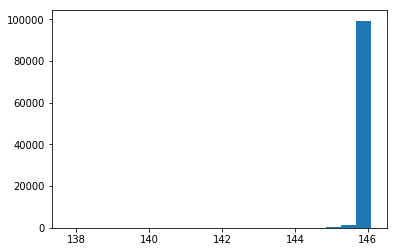

In [19]:
#Inspect initial histogram
num_bins =  20#1000#13500#20
#(full_n, full_bins, full_patches) = plt.hist(Full_Reduced_R_list, bins=num_bins)
(n_Z, bins, patches) = plt.hist(Reduced_Z_list, bins=num_bins)

In [20]:
#Get bin mids
print bins.shape
print bins

Z_bin_mids_list = []
for i in range(1, len(bins)):
    Z_bin_mids_list.append( (bins[i] + bins[i-1])/2 )
    
this_half_bid_width = .5*(Z_bin_mids_list[1] - Z_bin_mids_list[0])

#print bin_mids_list[-1]
#print bin_mids_list[-1]+this_half_bid_width
#print bin_mids_list[-1]-this_half_bid_width



(21,)
[137.7449646  138.16271667 138.58046875 138.99822083 139.4159729
 139.83372498 140.25147705 140.66922913 141.0869812  141.50473328
 141.92248535 142.34023743 142.7579895  143.17574158 143.59349365
 144.01124573 144.4289978  144.84674988 145.26450195 145.68225403
 146.1000061 ]


In [21]:
#Remove bins with n>10, & remove top bin
print n_Z.shape
print n_Z
print "\n"

counter = 0
new_bin_mids_list = []
new_n_list = []
for i in range(0, len(n_Z)):
    if n_Z[i] < 49. or n_Z[i] > 15000:
        #print( str(i)+": ("+str(bin_mids_list[i])+", "+str(n[i])+")" )
        counter +=1
    else:
        new_bin_mids_list.append(Z_bin_mids_list[i])
        new_n_list.append(n_Z[i])
"""
new_bin_mids_list = new_bin_mids_list[:-1]
new_n_list =new_n_list[:-1]

new_bin_mids_list = new_bin_mids_list[:-1]
new_n_list =new_n_list[:-1]

new_bin_mids_list = new_bin_mids_list[:-1]
new_n_list =new_n_list[:-1]

new_bin_mids_list = new_bin_mids_list[:-1]
new_n_list =new_n_list[:-1]

new_bin_mids_list = new_bin_mids_list[:-1]
new_n_list =new_n_list[:-1]
"""
print("\n\tcount = "+str(counter)+" / "+str(len(n_Z)))



(20,)
[1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 2.0000e+00 1.0000e+00
 3.0000e+00 1.3000e+01 1.8000e+01 4.9000e+01 1.2400e+02 4.4600e+02
 1.5450e+03 9.9261e+04]



	count = 16 / 20


In [22]:
#Inspect bins
print "bin_mids\t bin_count"
for i in range(0,len(Z_bin_mids_list)):
    print str(Z_bin_mids_list[i])+"\t"+str(n_Z[i])
    



bin_mids	 bin_count
137.95384063720704	1.0
138.37159271240233	0.0
138.78934478759766	0.0
139.20709686279298	0.0
139.62484893798828	0.0
140.0426010131836	0.0
140.4603530883789	0.0
140.87810516357422	0.0
141.29585723876954	0.0
141.71360931396484	1.0
142.13136138916016	2.0
142.54911346435546	1.0
142.96686553955078	3.0
143.3846176147461	13.0
143.8023696899414	18.0
144.22012176513672	49.0
144.63787384033202	124.0
145.05562591552734	446.0
145.47337799072267	1545.0
145.89113006591796	99261.0


In [23]:
#Inspect bins
print "\n-------\nNEW BINS"
print "bin_mids\t bin_count"
for i in range(0,len(new_bin_mids_list)):
    print str(new_bin_mids_list[i])+"\t"+str(new_n_list[i])


-------
NEW BINS
bin_mids	 bin_count
144.22012176513672	49.0
144.63787384033202	124.0
145.05562591552734	446.0
145.47337799072267	1545.0


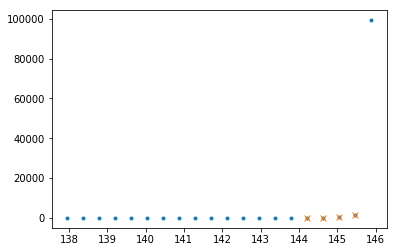

In [24]:
#Inspect elements with n>10
plt.plot(Z_bin_mids_list, n_Z, ".")
plt.plot(new_bin_mids_list,  new_n_list, 'x')

(array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
        1.e+05, 1.e+06, 1.e+07, 1.e+08]),
 <a list of 12 Text yticklabel objects>)

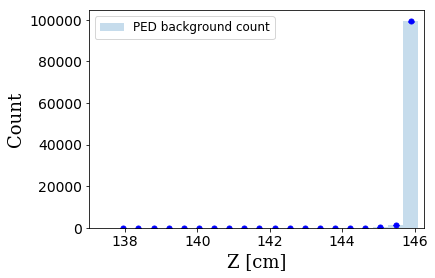

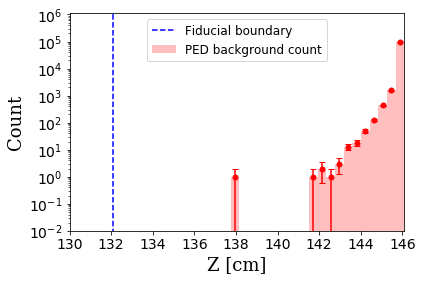

In [25]:
#R plot
num_bins=20
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)

ax.hist(Reduced_Z_list, bins=num_bins, alpha=0.25, label='PED background count')
ax.plot(Z_bin_mids_list, n_Z, ".b", markersize='10')
ax.errorbar(Z_bin_mids_list, np.asarray(n_Z), pow(np.asarray(n_Z),.5), ecolor='blue', capsize=3, fmt=' ')
pylab.legend(loc='upper left', fontsize=12)
#ax.set_yscale('log')
plt.xlim(137, 146.25)
#plt.ylim(0, 11000)


plt.xlabel('Z [cm]',fontsize=18,family='serif')
plt.ylabel('Count',fontsize=18,family='serif')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



fig = plt.figure(2)
ax = fig.add_subplot(1, 1, 1)

ax.hist(Reduced_Z_list, bins=num_bins, alpha=0.25, color='red', label='PED background count')
ax.plot(Z_bin_mids_list, n_Z, ".r", markersize='10')
ax.errorbar(Z_bin_mids_list, np.asarray(n_Z), pow(np.asarray(n_Z),.5), ecolor='red', capsize=3, fmt=' ')
ax.plot([132.1,132.1], [0,1e6], '--b', label='Fiducial boundary')
pylab.legend(loc='upper center', fontsize=12)
#ax.set_yscale('log')
plt.xlim(130., 146.1)
plt.ylim(.01, 1100000)

plt.xlabel('Z [cm]',fontsize=18,family='serif')
plt.ylabel('Count',fontsize=18,family='serif')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# - Get PED plots

In [26]:
#Remove events above fiducial & the bin closest to the wall

Full_Reduced_R_list = []
Reduced_R_list = []

R_forRZplot_list = []
Z_forRZplot_list = []
S1_forS1S2plot_list = []
S2_forS1S2plot_list = []

print("len(fLXeR_cm_list): "+str(len(fLXeR_cm_list))+"\n")
for i in range(0,len(fLXeR_cm_list)):
    if i %100000 == 0:
        print( "\t"+str(i)+" / "+str(len(fLXeR_cm_list)) )
    if fLXeZ_cm_list[i] < 1.45953906e2 and fLXeR_cm_list[i] < 72.7273224 and fLXeS1c_phe_list[i]> 0. and fLXeS2c_phe_list[i]> 0. and fLXeS1c_phe_list[i]< 425. and fLXeS2c_phe_list[i]< 305000.:
        R_forRZplot_list.append(fLXeR_cm_list[i])
        Z_forRZplot_list.append(fLXeZ_cm_list[i])
        S1_forS1S2plot_list.append(fLXeS1c_phe_list[i])
        S2_forS1S2plot_list.append(fLXeS2c_phe_list[i])
    if fLXeZ_cm_list[i] < 132.1:
        Reduced_R_list.append(fLXeR_cm_list[i])
        if fLXeR_cm_list[i] < 68.8:
            print("fiducial event:"+str(i)+"\t"+str(fLXeR_cm_list[i]) )

            
print( "\nlen(Reduced_R_list): "+str(len(Reduced_R_list)) )
print( "min(Reduced_R_list): "+str(min(Reduced_R_list)) )
print( "max(Reduced_R_list): "+str(max(Reduced_R_list)) )


print "\nlen(R_forRZplot_list): "+str(len(R_forRZplot_list))
print "len(Z_forRZplot_list): "+str(len(Z_forRZplot_list))
#print( "\nlen(Full_Reduced_R_list): "+str(len(Full_Reduced_R_list)) )
#print( "min(Full_Reduced_R_list): "+str(min(Full_Reduced_R_list)) )
#print( "max(Full_Reduced_R_list): "+str(max(Full_Reduced_R_list)) )


print "\n\t... Done!"

len(fLXeR_cm_list): 357442

	0 / 357442
	100000 / 357442
	200000 / 357442
	300000 / 357442

len(Reduced_R_list): 221843
min(Reduced_R_list): 69.06342
max(Reduced_R_list): 72.8

len(R_forRZplot_list): 48532
len(Z_forRZplot_list): 48532

	... Done!


In [27]:
print min(Reduced_R_list) - 68.8
print min(Reduced_Z_list) - 132.2

0.2634231567382841
5.544964599609386


In [28]:
#Find optimal bix size "Freedman-Diaconis rule"
from scipy.stats import iqr
print( iqr(Reduced_R_list) )
print( sum(Reduced_R_list) )

IQR = iqr(Reduced_R_list)

h = 2*IQR*pow(sum(Reduced_R_list), -1./3.)
print h

NumberOfBins = (  float(max(Reduced_R_list)) - float(min(Reduced_R_list))  ) / h

print" NumberOfBins: "+str( NumberOfBins)

0.03487396240234375
16136490.0
0.00027601219209295993
 NumberOfBins: 13537.734933683887


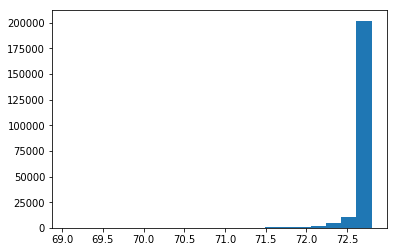

In [29]:
#Inspect initial histogram
num_bins =  20#1000#13500#20
#(full_n, full_bins, full_patches) = plt.hist(Full_Reduced_R_list, bins=num_bins)
(n_R, bins, patches) = plt.hist(Reduced_R_list, bins=num_bins)

In [30]:
#Get bin mids
print bins.shape
print bins

R_bin_mids_list = []
for i in range(1, len(bins)):
    R_bin_mids_list.append( (bins[i] + bins[i-1])/2 )
    
this_half_bid_width = .5*(R_bin_mids_list[1] - R_bin_mids_list[0])

#print bin_mids_list[-1]
#print bin_mids_list[-1]+this_half_bid_width
#print bin_mids_list[-1]-this_half_bid_width


(21,)
[69.06342316 69.25025215 69.43708115 69.62391014 69.81073914 69.99756813
 70.18439713 70.37122612 70.55805511 70.74488411 70.9317131  71.1185421
 71.30537109 71.49220009 71.67902908 71.86585808 72.05268707 72.23951607
 72.42634506 72.61317406 72.80000305]


In [31]:

#Remove bins with n>10, & remove top bin
print n_R.shape
print n_R
print "\n"

counter = 0
new_bin_mids_list = []
new_n_list = []
for i in range(0, len(n_R)):
    if n_R[i] < 50 or n_R[i] > 15000:
        #print( str(i)+": ("+str(bin_mids_list[i])+", "+str(n[i])+")" )
        counter +=1
    else:
        new_bin_mids_list.append(R_bin_mids_list[i])
        new_n_list.append(n_R[i])
"""
new_bin_mids_list = new_bin_mids_list[:-1]
new_n_list =new_n_list[:-1]

new_bin_mids_list = new_bin_mids_list[:-1]
new_n_list =new_n_list[:-1]

new_bin_mids_list = new_bin_mids_list[:-1]
new_n_list =new_n_list[:-1]

new_bin_mids_list = new_bin_mids_list[:-1]
new_n_list =new_n_list[:-1]

new_bin_mids_list = new_bin_mids_list[:-1]
new_n_list =new_n_list[:-1]
"""
print("\n\tcount = "+str(counter)+" / "+str(len(n_R)))


(20,)
[4.00000e+00 4.00000e+00 1.00000e+00 3.00000e+00 6.00000e+00 1.30000e+01
 2.30000e+01 2.20000e+01 5.30000e+01 8.20000e+01 1.07000e+02 1.75000e+02
 2.77000e+02 4.15000e+02 6.99000e+02 1.25600e+03 2.09600e+03 4.24200e+03
 1.02840e+04 2.02081e+05]



	count = 9 / 20


In [32]:
#Inspect bins
print "bin_mids\t bin_count"
for i in range(0,len(R_bin_mids_list)):
    print str(R_bin_mids_list[i])+"\t"+str(n_R[i])
    


bin_mids	 bin_count
69.15683765411377	4.0
69.34366664886474	4.0
69.53049564361572	1.0
69.7173246383667	3.0
69.90415363311767	6.0
70.09098262786866	13.0
70.27781162261962	23.0
70.4646406173706	22.0
70.65146961212159	53.0
70.83829860687256	82.0
71.02512760162354	107.0
71.2119565963745	175.0
71.39878559112549	277.0
71.58561458587647	415.0
71.77244358062744	699.0
71.95927257537842	1256.0
72.14610157012939	2096.0
72.33293056488037	4242.0
72.51975955963135	10284.0
72.70658855438232	202081.0


In [33]:
#Inspect bins
print "\n-------\nNEW BINS"
print "bin_mids\t bin_count"
for i in range(0,len(new_bin_mids_list)):
    print str(new_bin_mids_list[i])+"\t"+str(new_n_list[i])


-------
NEW BINS
bin_mids	 bin_count
70.65146961212159	53.0
70.83829860687256	82.0
71.02512760162354	107.0
71.2119565963745	175.0
71.39878559112549	277.0
71.58561458587647	415.0
71.77244358062744	699.0
71.95927257537842	1256.0
72.14610157012939	2096.0
72.33293056488037	4242.0
72.51975955963135	10284.0


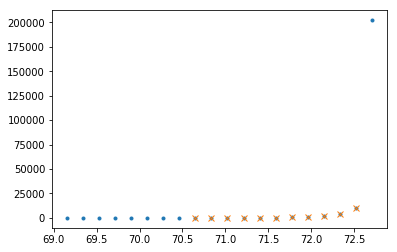

In [34]:
#Inspect elements with n>10
plt.plot(R_bin_mids_list, n_R, ".")
plt.plot(new_bin_mids_list,  new_n_list, 'x')

expfit popt: [3.42885024e-14 9.99999993e-01]
expfit popt: [3.42885024e-14 9.99999993e-01]


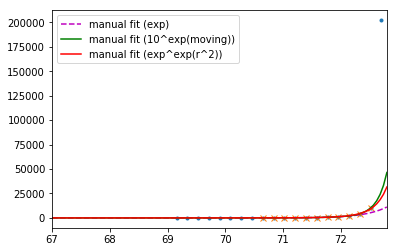

In [35]:
#Try exp(a*x+b) fit
from numpy import vectorize


def expfunc(x, a, b):
    return a*np.exp(b*x)

def secondfunc(x,a,b):
    return pow(10, a*np.exp(b*x))-1.

#20bins
def thirdfunc(x):
    ##if x>72.1461015701294-this_half_bid_width:
    ##    a= (0.0000000000000762679346785136*x*x)-(0.0000000000110335877551974*x)+0.00000000039905322756851
    ##    b= (12.7324570202181*x*x)-(1836.83364965032*x)+66247.5792370686
    #if x>72.5197595596314-this_half_bid_width:
    #    a=3.16261232354074E-047
    #    b=1.49558454031935
    if x>72.3329305648804-this_half_bid_width:
        a=4.13468150309631E-17
        b=0.539354608766463
    elif x>72.1461015701294-this_half_bid_width:
        a=5.40696932772997e-15
        b=.471979367852657

    else:
        #13 ndf
        a=0.0000000000000711971915742482
        b=0.436360251417053
        ##16 ndf
        #a=4.85380871256191e-16
        #b=0.505902751002283
    return pow(10, a*np.exp(b*x))-1. - 1.638689184346731e-13

#Exponential of an exponential of r^2
def fourthfunc(x):
    #if x>72.3329305648804-this_half_bid_width:
    #    a=0.0000000289181958992141
    #    b= 0.00372346974228
    #if x>72.1461015701294-this_half_bid_width:
    #    a= 0.000000315438168079885
    #    b= 0.003266767231743
    #
    #else:
    #    #13 ndf
    a= 0.000000851712003876851
    b= 0.003078231418548
        
    return np.exp( a*np.exp(b*x*x) ) - 1.0000008517123666

#virtualize function for arrays
vthirdfunc=vectorize(thirdfunc)
vfourthfunc=vectorize(fourthfunc)

popt, pcov = curve_fit(expfunc,  np.asarray(new_bin_mids_list),  new_n_list)
print("expfit popt: "+str(popt) )

#init_vals =   [1.33840279614242E-082, 2.72085733292357]#[ 2.8249676855139E-154,  5.16127526504611]  
#popt, pcov = curve_fit(expfunc, new_bin_mids_list,   new_n_list, p0=init_vals)
print("expfit popt: "+str(popt) )

xdata = linspace(67, 72.8, 100)

Aexp= 4.88384969953724E-080#1.33840279614242E-082
Bexp= 2.63654158972956#2.72085733292357

Asec= 0.0000000000000711971915742482#0.0000000000000771800856977284#0.0000000000000522012010892923#   
Bsec= 0.436360251417053#0.435235668908354#0.440718337956085#                    


plt.plot(R_bin_mids_list, n_R, ".")
plt.plot(new_bin_mids_list,  new_n_list, 'x')
#plt.plot(xdata, expfunc(xdata, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.plot(xdata, expfunc(xdata, Aexp, Bexp), 'm--',label='manual fit (exp)')
#plt.plot(xdata, secondfunc(xdata, Asec, Bsec), 'r-',label='manual fit (10^(exp))')
plt.plot(xdata, vthirdfunc(xdata), 'g-',label='manual fit (10^exp(moving))')
plt.plot(xdata, vfourthfunc(xdata), 'r-',label='manual fit (exp^exp(r^2))')


plt.xlim(67, 72.8)
#plt.ylim(0, 4000)
plt.legend()



In [36]:
print this_half_bid_width

0.09341449737548402


#- The bins are too wide for the top of the histogram. But if I make them any smaller they won't be usable closer to the centre of the detector

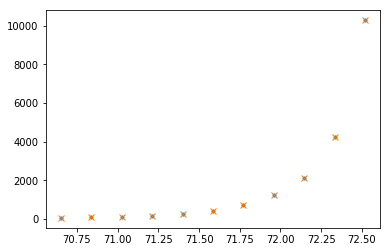

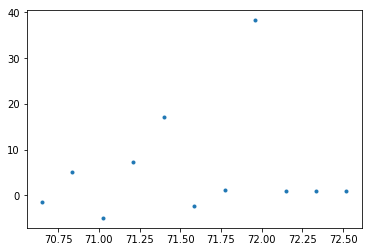

In [37]:
#plot residual
figure(1)
plt.plot(new_bin_mids_list,  new_n_list, ".")
#plt.plot(new_bin_mids_list, secondfunc(np.asarray(new_bin_mids_list), Asec, Bsec), 'x',label='manual fit')
plt.plot(new_bin_mids_list, vthirdfunc(np.asarray(new_bin_mids_list)), 'x',label='manual fit')

figure(2)
#plt.plt.plot(new_bin_mids_list, np.asarray(new_n_list) - secondfunc(np.asarray(new_bin_mids_list), Asec, Bsec), ".")
plt.plot(new_bin_mids_list, np.asarray(new_n_list) - vthirdfunc(np.asarray(new_bin_mids_list)), ".")




In [38]:
for i in range(0, len(new_bin_mids_list)):
    #print new_bin_mids_list[i]
    print np.asarray(new_n_list)[i] - secondfunc(np.asarray(new_bin_mids_list[i]), Asec, Bsec)

-1.4600537210039022
4.9965004722758835
-4.935475149170259
7.267814222421862
17.158750028410907
-2.4305967255130554
1.2781856775867482
38.29189736963349
-131.5183980288275
-46.40391857477789
1556.6333386235874


In [39]:
#Chi Square
#Get P value https://www.socscistatistics.com/pvalues/chidistribution.aspx

def ChiSquare(obs_list, exp_list):
    if len(obs_list) == len(exp_list):
        X_list = []
        for i in range(len(obs_list)):
            X_list.append(pow(obs_list[i] - exp_list[i], 2) / exp_list[i])
        return sum(X_list)
    else:
        print("lists of different lengths")
        return -999

#print len(new_n_list)
#print len(expfunc(np.asarray(new_bin_mids_list), *popt))
#print len(new_bin_mids_list)

print("\n\tnDF: \t"+str(len(new_n_list)+2))
print "\tChi^2: \t"+str(  ChiSquare(new_n_list, expfunc(np.asarray(new_bin_mids_list), Aexp, Bexp))  )

print "\nsecond function"
print("\n\tnDF: \t"+str(len(new_n_list)+2))
print "\tChi^2: \t"+str(  ChiSquare(new_n_list, secondfunc(np.asarray(new_bin_mids_list), Asec, Bsec))  )

print "\nthird function"
print("\n\tnDF: \t"+str(len(new_n_list)+2))
print "\tChi^2: \t"+str(  ChiSquare(new_n_list, vthirdfunc(np.asarray(new_bin_mids_list)))  )

#20 bins, 13 ndf, 3.25 Chi2, .997 p-value

print "\nfourth function"
print("\n\tnDF: \t"+str(len(new_n_list)+2))
print "\tChi^2: \t"+str(  ChiSquare(new_n_list, vfourthfunc(np.asarray(new_bin_mids_list)))  )

print "\n\n...done!"


	nDF: 	13
	Chi^2: 	4937.057459778388

second function

	nDF: 	13
	Chi^2: 	289.16162177019174

third function

	nDF: 	13
	Chi^2: 	3.2503926937235335

fourth function

	nDF: 	13
	Chi^2: 	131.80395450932212


...done!


(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06]), <a list of 9 Text yticklabel objects>)

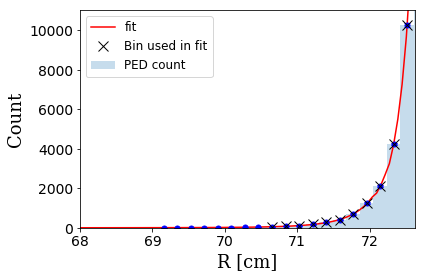

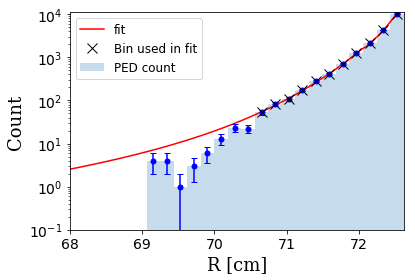

In [40]:
#R plot
num_bins=20
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)

#ax.plot(xdata, expfunc(xdata, *popt), 'r-',label='fit: exp(%5.3f*r %5.3f)' % tuple(popt))
ax.plot(xdata, vthirdfunc(xdata), 'r-',label='fit')
#ax.plot(xdata, vfourthfunc(xdata), 'r-',label='fit')
ax.hist(Reduced_R_list, bins=num_bins, alpha=0.25, label='PED count')
ax.plot(R_bin_mids_list, n_R, ".b", markersize='10')
#ax.errorbar(bin_mids_list, np.asarray(n), 1./pow(np.asarray(n),.5), ecolor='blue', capsize=3, fmt=' ')
ax.errorbar(R_bin_mids_list, np.asarray(n_R), pow(np.asarray(n_R),.5), ecolor='blue', capsize=3, fmt=' ')
ax.plot(new_bin_mids_list,  new_n_list, 'xk', markersize='10', label="Bin used in fit")
pylab.legend(loc='upper left', fontsize=12)
#ax.set_yscale('log')
plt.xlim(68, 72.625)
plt.ylim(0, 11000)


plt.xlabel('R [cm]',fontsize=18,family='serif')
plt.ylabel('Count',fontsize=18,family='serif')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig = plt.figure(2)
ax = fig.add_subplot(1, 1, 1)

#ax.plot(xdata, expfunc(xdata, *popt), 'r-',label='fit: exp(%5.3f*r %5.3f)' % tuple(popt))
ax.plot(xdata, vthirdfunc(xdata), 'r-',label='fit')
#ax.plot(xdata, vfourthfunc(xdata), 'r-',label='fit')
ax.hist(Reduced_R_list, bins=num_bins, alpha=0.25, label='PED count')
ax.plot(R_bin_mids_list, n_R, ".b", markersize='10')
#ax.errorbar(bin_mids_list, np.asarray(n), 1./pow(np.asarray(n),.5), ecolor='blue', capsize=3, fmt=' ')
ax.errorbar(R_bin_mids_list, np.asarray(n_R), pow(np.asarray(n_R),.5), ecolor='blue', capsize=3, fmt=' ')
ax.plot(new_bin_mids_list,  new_n_list, 'xk', markersize='10', label="Bin used in fit")
pylab.legend(loc='best', fontsize=12)
#ax.set_yscale('log')
plt.xlim(68, 72.625)
plt.ylim(.1, 11000)

plt.xlabel('R [cm]',fontsize=18,family='serif')
plt.ylabel('Count',fontsize=18,family='serif')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
        1.e+05, 1.e+06, 1.e+07, 1.e+08]),
 <a list of 12 Text yticklabel objects>)

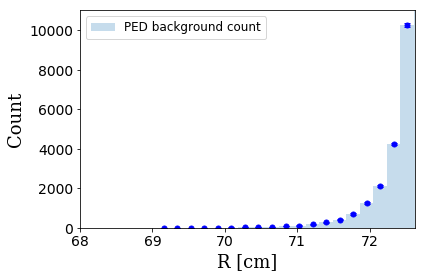

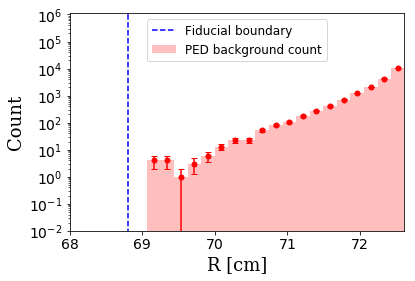

In [41]:
#R plot
num_bins=20
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)

ax.hist(Reduced_R_list, bins=num_bins, alpha=0.25, label='PED background count')
ax.plot(R_bin_mids_list, n_R, ".b", markersize='10')
#ax.errorbar(bin_mids_list, np.asarray(n), 1./pow(np.asarray(n),.5), ecolor='blue', capsize=3, fmt=' ')
ax.errorbar(R_bin_mids_list, np.asarray(n_R), pow(np.asarray(n_R),.5), ecolor='blue', capsize=3, fmt=' ')
#ax.plot(new_bin_mids_list,  new_n_list, 'xk', markersize='10', label="Bin used in fit")
pylab.legend(loc='upper left', fontsize=12)
#ax.set_yscale('log')
plt.xlim(68, 72.625)
plt.ylim(0, 11000)


plt.xlabel('R [cm]',fontsize=18,family='serif')
plt.ylabel('Count',fontsize=18,family='serif')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig = plt.figure(2)
ax = fig.add_subplot(1, 1, 1)

ax.hist(Reduced_R_list, bins=num_bins, alpha=0.25, color='red', label='PED background count')
ax.plot(R_bin_mids_list, n_R, ".r", markersize='10')
ax.errorbar(R_bin_mids_list, np.asarray(n_R), pow(np.asarray(n_R),.5), ecolor='red', capsize=3, fmt=' ')
ax.plot([68.8,68.8], [0,1e6], '--b', label='Fiducial boundary')
pylab.legend(loc='upper center', fontsize=12)
#ax.set_yscale('log')
plt.xlim(68, 72.61)
plt.ylim(.01, 1100000)

plt.xlabel('R [cm]',fontsize=18,family='serif')
plt.ylabel('Count',fontsize=18,family='serif')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

0.0	0.0
10.0	3.07008723332558e-07
20.0	2.0659630042274557e-06
30.0	1.2746090729542914e-05
40.0	0.00011644680115785455
50.0	0.0018734813009417817
60.0	0.05689173842412565
70.0	19.61928390219918
72.8	31623.994436090084


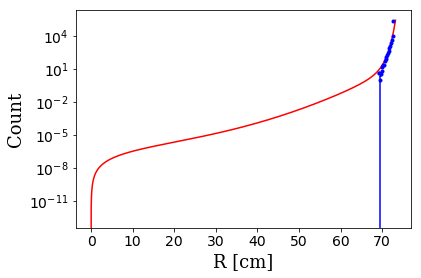

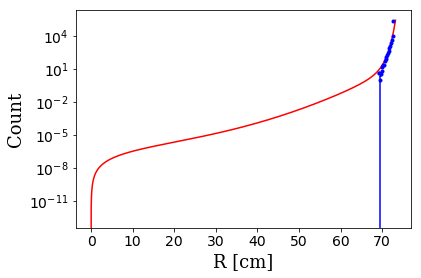

In [42]:
#Compare to centre
xdata2=np.arange(0, 73.22, .01)
figure(1)
plt.plot(xdata2, vfourthfunc(xdata2), 'r-',label='manual fit')
#plt.plot(xdata2, vthirdfunc(xdata2), 'r-',label='manual fit')
plt.plot(R_bin_mids_list, n_R, ".b")
plt.errorbar(R_bin_mids_list, np.asarray(n_R), 1./pow(np.asarray(n_R),.5), ecolor='blue', capsize=1, fmt=' ')
#plt.yscale('log')
plt.xlabel('R [cm]',fontsize=18,family='serif')
plt.ylabel('Count',fontsize=18,family='serif')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

figure(2)
plt.plot(xdata2, vfourthfunc(xdata2), 'r-',label='manual fit')
#plt.plot(xdata2, vthirdfunc(xdata2), 'r-',label='manual fit')
plt.plot(R_bin_mids_list, n_R, ".b")
plt.errorbar(R_bin_mids_list, np.asarray(n_R), 1./pow(np.asarray(n_R),.5), ecolor='blue', capsize=1, fmt=' ')
plt.yscale('log')
plt.xlabel('R [cm]',fontsize=18,family='serif')
plt.ylabel('Count',fontsize=18,family='serif')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

for i in range(0, len (xdata2)):
    if xdata2[i] % 10 == 0 or xdata2[i] ==72.8:
        print str(xdata2[i])+"\t"+str(fourthfunc(xdata2[i]))


In [43]:
#integrate
xlo = 0
xhi= 68.8
n_rectangles =1000000

x = np.linspace(xlo,xhi,n_rectangles)
print x

#vthirdfunc


#integrate using trapazoid rule
def trap(f, xmin, xmax, npoints=10):
    area=0
    x=np.linspace(xmin, xmax, npoints)
    N=len(x)
    dx= x[1] - x[0]
    
    for k in range(1, N):
        area += (f(x[k-1]) +f(x[k])) * dx / 2
    return area

#integral = trap(vthirdfunc, 1, 68.8, n_rectangles)
integral = trap(vfourthfunc, 0, 68.8, n_rectangles)

print "Integral: "+str(integral)
#47900 run days assuming 1 Hz constant rate
print "Normalised Integral (1 hZ): "+str(integral / 70.8)
print "Normalised Integral (0.02 hZ): "+str(.02*integral / 70.8)

[0.00000000e+00 6.88000688e-05 1.37600138e-04 ... 6.87998624e+01
 6.87999312e+01 6.88000000e+01]
Integral: 7.577865401784787
Normalised Integral (1 hZ): 0.1070319972003501
Normalised Integral (0.02 hZ): 0.002140639944007002


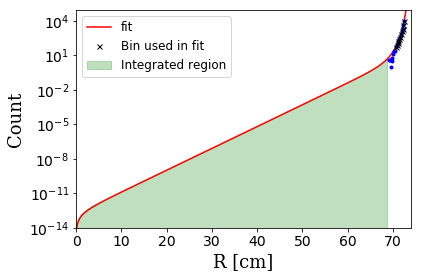

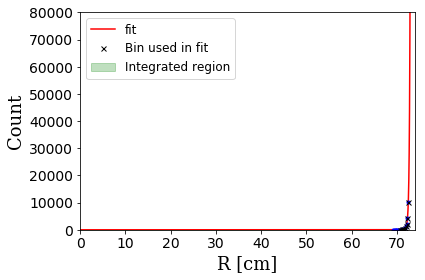

In [44]:
figure(1)
plt.plot(xdata2, vthirdfunc(xdata2), 'r-', label='fit')
plt.fill_between(x, vthirdfunc(x), alpha=.25, color='green',label='Integrated region')
plt.plot(R_bin_mids_list, n_R, ".b")
plt.plot(new_bin_mids_list,  new_n_list, 'xk', markersize=5, label="Bin used in fit")
plt.xlim(0,74)
plt.ylim(1e-14,8e4)
plt.yscale('log')
plt.xlabel('R [cm]',fontsize=18,family='serif')
plt.ylabel('Count',fontsize=18,family='serif')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
pylab.legend(loc='best', fontsize=12)

figure(2)
plt.plot(xdata2, vthirdfunc(xdata2), 'r-', label='fit')
plt.fill_between(x, vthirdfunc(x), alpha=.25, color='green',label='Integrated region')
plt.plot(R_bin_mids_list, n_R, ".b")
plt.plot(new_bin_mids_list,  new_n_list, 'xk', markersize=5, label="Bin used in fit")
plt.xlim(0,74)
plt.ylim(0,8e4)
plt.xlabel('R [cm]',fontsize=18,family='serif')
plt.ylabel('Count',fontsize=18,family='serif')
#plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
pylab.legend(loc='best', fontsize=12)

In [45]:
print thirdfunc(0.0)

0.0


In [46]:
#import sympy as sy
#x=sy.Symbol('x')
#sy.integrate(vthirdfunc(x), (x, 0, 68.8) )

In [47]:
#from scipy import quad
#integrate.quad(vthirdfunc, 0, 68.8)

# - R, Z, S1, S2 plots

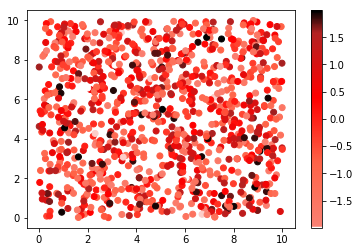

In [48]:
#Custom colormap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
#rvb = make_colormap(
#    [c('white'), c('violet'), 0.33, c('violet'), c('blue'), 0.66, c('blue'), c('black')])

Peters = make_colormap(
    #[c('white'), c('red'), 0.5, c('red'), c('black')])
    #[c('white'), c('yellow'), 0.25, c('yellow'), c('orange'), 0.5, c('orange'), c('red'), 0.75, c('red'), c('black')])
    [c('white'), c('salmon'), 0.01, c('salmon'), c('tomato'), 0.3, c('tomato'), c('red'), 0.6, c('red'), c('firebrick'), 0.9, c('firebrick'), c('black')])
#Test colormap
N = 1000
array_dg = np.random.uniform(0, 10, size=(N, 2))
colors = np.random.uniform(-2, 2, size=(N,))
plt.scatter(array_dg[:, 0], array_dg[:, 1], c=colors, cmap=Peters)
plt.colorbar()
plt.show()

In [49]:
R_square = np.asarray(fLXeR_cm_list)*np.asarray(fLXeR_cm_list)
Z = np.asarray(fLXeZ_cm_list)

/cvmfs/sft.cern.ch/lcg/views/LCG_95/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


ValueError: x and y must have same first dimension, but have shapes (3500,) and (3000,)

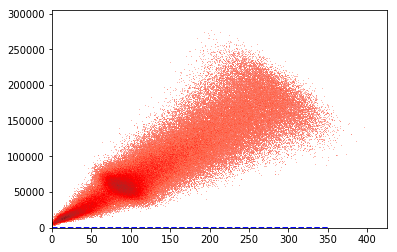

357442
357442


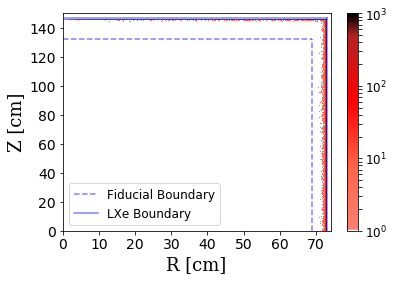

In [50]:
#plot R vs Z
num_bins=339#50


r = linspace(0, 68.8, 2)
z_fid = linspace(132.1, 132.1, 2)
z = linspace(0, 132.1, 2)
r_fid = linspace(68.8, 68.8, 2)

z_top = linspace(146.55, 146.55, 2)
z2 = linspace(0, 146.55, 2)


r2 = linspace(0, 73.01, 2)
r_top = linspace(73.01, 73.01, 2)

figure(1)
plt.plot(r, z_fid, '--', c='blue', alpha=.5, label='Fiducial Boundary')
plt.plot(r_fid, z, '--', c='blue', alpha=.5)

plt.plot(r2, z_top, '-', c='blue', alpha=.5, label='LXe Boundary')
plt.plot(r_top, z2, '-', c='blue', alpha=.5)


matplotlib.pyplot.hist2d(fLXeR_cm_list, fLXeZ_cm_list, norm=mpl.colors.LogNorm(), bins=num_bins, cmap=Peters)#, normed=True)



#matplotlib.pyplot.hist2d(fLXeR_cm_list, fLXeZ_cm_list, 50, cmap=Peters)
#matplotlib.pyplot.hist2d(R_square, Z, 75, cmap=Peters)


plt.xlabel('R [cm]',fontsize=18,family='serif')
plt.ylabel('Z [cm]',fontsize=18,family='serif')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 74)
plt.ylim(0, 150)

cb=plt.colorbar()
#cb=plt.colorbar(ticks=[3.05e-5, 1.71e-4, 9.60e-4, 5.39e-3, 3.02e-2])
#cb.ax.set_yticklabels(['3.05e-5', '1.71e-4', '9.60e-4', '5.39e-3', '3.02e-2']) 




#cb=plt.colorbar(ticks=[1, 2.8, 5, 9.1, 16.3, 29.4, 52.9, 95.3, 171.5, 308.6,  550,1e3, 1.8e3])
#cb.ax.set_yticklabels(['1.2e-5', '2.2e-5', '4.0e-5', '7.1e-5', '1.3e-4', '2.3e-4', '4.1e-4', '7.5e-5', '1.3e-3']) 

#cb=plt.colorbar(ticks=[0, 1048.5, 2097, 3145.5, 4194, 5242.5, 6291, 7339.5, 8388])
#cb.ax.set_yticklabels(['0.0', '0.03', '0.05', '0.08', '0.11', '0.13', '0.16', '0.19', '0.21']) 
cb.ax.tick_params(labelsize=12)

#plt.savefig('deleteme.png')


#cb = plt.colorbar(ticks=[0, 1e4, 2e4, 3e4, 39454])
#cb.ax.set_yticklabels(['0', '0.1', '0.2', '0.3', '0.4']) 

pylab.legend(loc='lower left', fontsize=12)

print len(fLXeR_cm_list)
print len(fLXeZ_cm_list)

(array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
        1.e+05, 1.e+06, 1.e+07, 1.e+08]),
 <a list of 12 Text yticklabel objects>)

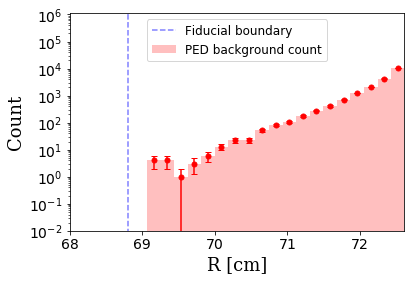

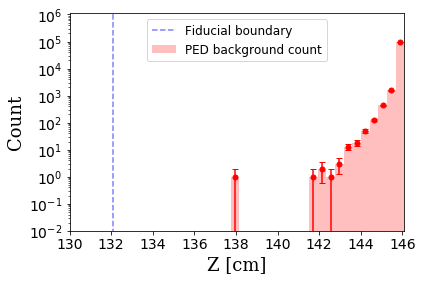

In [51]:
num_bins=20

fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)

ax.hist(Reduced_R_list, bins=num_bins, alpha=0.25, color='red', label='PED background count')
ax.plot(R_bin_mids_list, n_R, ".r", markersize='10')
ax.errorbar(R_bin_mids_list, np.asarray(n_R), pow(np.asarray(n_R),.5), ecolor='red', capsize=3, fmt=' ')
ax.plot([68.8,68.8], [0,1e6], '--b', alpha=.5, label='Fiducial boundary')
pylab.legend(loc='upper center', fontsize=12)
#ax.set_yscale('log')
plt.xlim(68, 72.61)
plt.ylim(.01, 1100000)

plt.xlabel('R [cm]',fontsize=18,family='serif')
plt.ylabel('Count',fontsize=18,family='serif')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig = plt.figure(2)
ax = fig.add_subplot(1, 1, 1)

ax.hist(Reduced_Z_list, bins=num_bins, alpha=0.25, color='red', label='PED background count')
ax.plot(Z_bin_mids_list, n_Z, ".r", markersize='10')
ax.errorbar(Z_bin_mids_list, np.asarray(n_Z), pow(np.asarray(n_Z),.5), ecolor='red', capsize=3, fmt=' ')
ax.plot([132.1,132.1], [0,1e6], '--b', alpha=.5, label='Fiducial boundary')
pylab.legend(loc='upper center', fontsize=12)
#ax.set_yscale('log')
plt.xlim(130., 146.1)
plt.ylim(.01, 1100000)

plt.xlabel('Z [cm]',fontsize=18,family='serif')
plt.ylabel('Count',fontsize=18,family='serif')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

[Text(1,0,u'$\\mathdefault{10^{0}}$'),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u'$\\mathdefault{10^{1}}$'),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u'$\\mathdefault{10^{2}}$'),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u'$\\mathdefault{10^{3}}$')]

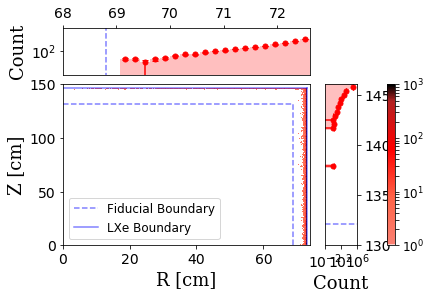

In [52]:
num_bins=339#50
R_num_bins=20

fig = plt.figure()

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

counts, xedges, yedges, img = ax_joint.hist2d(fLXeR_cm_list, fLXeZ_cm_list, norm=mpl.colors.LogNorm(), bins=num_bins, cmap=Peters)#, normed=True)
ax_joint.plot(r, z_fid, '--', c='blue', alpha=.5, label='Fiducial Boundary')
ax_joint.plot(r_fid, z, '--', c='blue', alpha=.5)
ax_joint.plot(r2, z_top, '-', c='blue', alpha=.5, label='LXe Boundary')
ax_joint.plot(r_top, z2, '-', c='blue', alpha=.5)
ax_joint.legend(loc='lower left', fontsize=12)

ax_joint.set_xlim(0, 74)
ax_joint.set_ylim(0, 150)


ax_marg_x.hist(Reduced_R_list, bins=R_num_bins, alpha=0.25, color='red')
ax_marg_x.plot(R_bin_mids_list, n_R, ".r", markersize='10')
ax_marg_x.errorbar(R_bin_mids_list, np.asarray(n_R), pow(np.asarray(n_R),.5), ecolor='red', capsize=3, fmt=' ')
ax_marg_x.plot([68.8,68.8], [0,1e6], '--b', alpha=.5)
#ax_marg_x.plot(r_top, z2, '-', c='blue', alpha=.5)
ax_marg_x.set_yscale('log')
ax_marg_x.xaxis.tick_top()
ax_marg_x.set_xlim(68, 72.61)
ax_marg_x.set_ylim(.005, 1100000)

ax_marg_y.hist(Reduced_Z_list, bins=R_num_bins, alpha=0.25, color='red', orientation=u'horizontal')
ax_marg_y.plot(n_Z, Z_bin_mids_list, ".r", markersize='10')
ax_marg_y.errorbar(np.asarray(n_Z), Z_bin_mids_list, xerr=pow(np.asarray(n_Z),.5), ecolor='red', capsize=3, fmt=' ')

ax_marg_y.plot([0,1e6], [132.1,132.1], '--b', alpha=.5)
ax_marg_y.set_xscale('log')
ax_marg_y.yaxis.tick_right()
ax_marg_y.set_xlim(.01, 1100000)
ax_marg_y.set_ylim(130., 146.1)

# Turn off tick labels on marginals
#plt.setp(ax_marg_x.get_xticklabels(), visible=False)
#plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Joint x label')
ax_joint.set_ylabel('Joint y label')

ax_joint.set_ylabel('Z [cm]',fontsize=18,family='serif')
ax_joint.set_xlabel('R [cm]',fontsize=18,family='serif')
ax_joint.tick_params(axis='both', which='major', labelsize=14)
ax_joint.tick_params(axis='both', which='major', labelsize=14)



# Set labels on marginals
#ax_marg_y.set_xlabel('Marginal x label')
ax_marg_y.set_xlabel('Count',fontsize=18,family='serif')
ax_marg_x.set_ylabel('Count',fontsize=18,family='serif')

ax_marg_x.tick_params(axis='both', which='major', labelsize=14)
ax_marg_y.tick_params(axis='both', which='major', labelsize=14)
#ax_marg_x.set_xticks(fontsize=14)
#plt.ylabel('Probability',fontsize=18,family='serif')

cbar = fig.colorbar(img, pad=.4)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=12)


In [53]:
print max(Reduced_Z_list)

146.1


fid = 228502 / 355030 = 0.643613215785


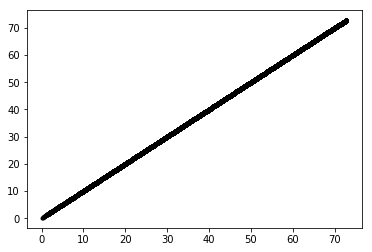

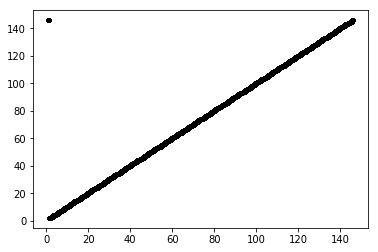

In [54]:
#Get RZ distribution without field adjustment

MDC2adj_fLXeR_cm_list = []
MDC2adj_fLXeZ_cm_list = []

MDC2adj_Reduced_R_list=[]
MDC2adj_Reduced_Z_list=[]

fid_counter = 0

temp_r_list =[]
other_temp_r_list=[]
temp_z_list =[]
other_temp_z_list=[]

max_DT= max(DT_us_list)

ii=0
for ii in range(0,len(fLXeR_cm_list)):
    #print "fLXeR_cm_list[ii]: "+str(fLXeR_cm_list[ii])
    #print "fLXeZ_cm_list[ii]: "+str(fLXeZ_cm_list[ii])

    r= fLXeR_cm_list[ii]
    z= fLXeZ_cm_list[ii]
    if fLXeR_cm_list[ii] >72.8:
        r=72.8
    if fLXeZ_cm_list[ii] > 146:
        z=146
    elif fLXeZ_cm_list[ii] < 1.1:
        z=1.1


    i=int( (r_m*round(r*10)/10) +z_m*round(z)+z_c )#1450
    #print "i = "+str(i)
    #print str(r)+"\t"+str(z)+"\t|\t"+str(rIN_cm_list[i])+"\t"+str(zIN_cm_list[i])
    #print str(z)+"\t|\t"+str(zIN_cm_list[i])
    temp_r_list.append(r)
    other_temp_r_list.append(rIN_cm_list[i])
    temp_z_list.append(z)
    other_temp_z_list.append(zIN_cm_list[i])

    if z < 20. and rOUT_cm_list[i] > 60.:
        continue
    else:
        newZ= 0.15*(max_DT-DT_us_list[i])

        MDC2adj_fLXeZ_cm_list.append(z)
        MDC2adj_Reduced_Z_list.append(z)
        #MDC2adj_fLXeZ_cm_list.append(newZ)
        #MDC2adj_Reduced_Z_list.append(newZ)

        MDC2adj_fLXeR_cm_list.append(rOUT_cm_list[i])
        MDC2adj_Reduced_R_list.append(rOUT_cm_list[i])

        if newZ < 132.1 and newZ > 1.5 and rOUT_cm_list[i]<68.8:
            fid_counter +=1
            
"""
if fLXeZ_cm_list[i] > 132.1 and fLXeR_cm_list[i] < 68.8:
        Reduced_Z_list.append(fLXeZ_cm_list[i])
"""

print "fid = "+str(fid_counter)+" / "+str(len(MDC2adj_fLXeR_cm_list))+" = "+str( float(fid_counter)/float(len(MDC2adj_fLXeR_cm_list)) )     

figure(1)
plt.plot(temp_r_list, other_temp_r_list, '.k')

figure(2)
plt.plot(temp_z_list, other_temp_z_list, '.k')


In [55]:
print max(DT_us_list)

915.308


(0, 3)

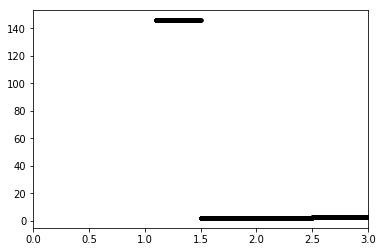

In [56]:
figure(2)
plt.plot(temp_z_list, other_temp_z_list, '.k')
plt.xlim(0,3)


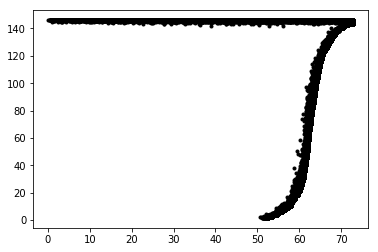

In [57]:
a=np.asarray(MDC2adj_fLXeR_cm_list)
b=np.asarray(MDC2adj_fLXeZ_cm_list)

cuts = (a > 60.) & (b<20.)

figure(1)
plt.plot(a, b, '.k')
#plt.xlim(65,75)
#plt.ylim(135, 146.2)

357442
357442


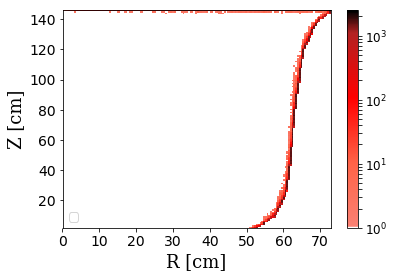

In [58]:
#plot R vs Z with MDC2 adjustment
num_bins=150#339#50


r = linspace(0, 68.8, 2)
z_fid = linspace(132.1, 132.1, 2)
z = linspace(0, 132.1, 2)
r_fid = linspace(68.8, 68.8, 2)

z_top = linspace(146.55, 146.55, 2)
z2 = linspace(0, 146.55, 2)

r2 = linspace(0, 73.01, 2)
r_top = linspace(73.01, 73.01, 2)

figure(1)
#plt.plot(r, z_fid, '--', c='blue', alpha=.5, label='Fiducial Boundary')
#plt.plot(r_fid, z, '--', c='blue', alpha=.5)

#plt.plot(r2, z_top, '-', c='blue', alpha=.5, label='LXe Boundary')
#plt.plot(r_top, z2, '-', c='blue', alpha=.5)

#counts, xedges, yedges, img = matplotlib.pyplot.hist2d(MDC2adj_fLXeR_cm_list, MDC2adj_fLXeZ_cm_list, norm=mpl.colors.LogNorm(), bins=num_bins, cmap=Peters)#, normed=True)
counts, xedges, yedges, im = matplotlib.pyplot.hist2d(MDC2adj_fLXeR_cm_list, MDC2adj_fLXeZ_cm_list, norm=mpl.colors.LogNorm(), bins=num_bins, cmap=Peters)#, normed=True)



plt.xlabel('R [cm]',fontsize=18,family='serif')
plt.ylabel('Z [cm]',fontsize=18,family='serif')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 74)
#plt.ylim(0, 150)

cb=plt.colorbar(im)
cb.ax.tick_params(labelsize=12)


pylab.legend(loc='lower left', fontsize=12)

print len(fLXeR_cm_list)
print len(fLXeZ_cm_list)

[Text(1,0,u'$\\mathdefault{10^{0}}$'),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u'$\\mathdefault{10^{1}}$'),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u'$\\mathdefault{10^{2}}$'),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u''),
 Text(1,0,u'$\\mathdefault{10^{3}}$')]

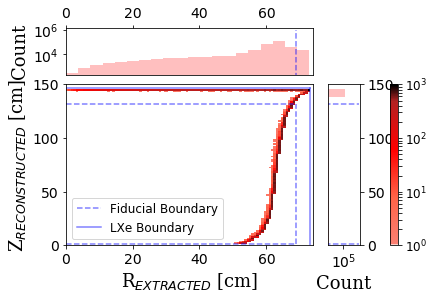

In [59]:
num_bins=100#50
R_num_bins=20

fig = plt.figure()

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

#counts, xedges, yedges, img = ax_joint.hist2d(MDC2adj_fLXeR_cm_list, MDC2adj_fLXeZ_cm_list, norm=mpl.colors.LogNorm(), bins=num_bins, cmap=Peters)#, normed=True)
ax_joint.hist2d(MDC2adj_fLXeR_cm_list, MDC2adj_fLXeZ_cm_list, norm=mpl.colors.LogNorm(), bins=num_bins, cmap=Peters)#, normed=True)
ax_joint.plot([68.8, 68.8], [1.5, 132.1], '--', c='blue', alpha=.5, label='Fiducial Boundary')
ax_joint.plot([0,68.8], [132.1,132.1], '--', c='blue', alpha=.5)
ax_joint.plot([0,68.8], [1.5,1.5], '--', c='blue', alpha=.5)

ax_joint.plot(r2, z_top, '-', c='blue', alpha=.5, label='LXe Boundary')
ax_joint.plot(r_top, z2, '-', c='blue', alpha=.5)
ax_joint.legend(loc='lower left', fontsize=12)

ax_joint.set_xlim(0, 74)
ax_joint.set_ylim(0, 150)


ax_marg_x.hist(MDC2adj_Reduced_R_list, bins=R_num_bins, alpha=0.25, color='red')
#ax_marg_x.plot(R_bin_mids_list, n_R, ".r", markersize='10')
#ax_marg_x.errorbar(R_bin_mids_list, np.asarray(n_R), pow(np.asarray(n_R),.5), ecolor='red', capsize=3, fmt=' ')
ax_marg_x.plot([68.8,68.8], [0,1e6], '--b', alpha=.5)


#ax_marg_x.plot(r_top, z2, '-', c='blue', alpha=.5)
ax_marg_x.set_yscale('log')
ax_marg_x.xaxis.tick_top()
ax_marg_x.set_xlim(0, 74)
#ax_marg_x.set_ylim(.01, 1100000)

ax_marg_y.hist(MDC2adj_Reduced_Z_list, bins=R_num_bins, alpha=0.25, color='red', orientation=u'horizontal')
#ax_marg_y.plot(n_Z, Z_bin_mids_list, ".r", markersize='10')
#ax_marg_y.errorbar(np.asarray(n_Z), Z_bin_mids_list, xerr=pow(np.asarray(n_Z),.5), ecolor='red', capsize=3, fmt=' ')
ax_marg_y.plot([0,1e6], [132.1,132.1], '--b', alpha=.5)
ax_marg_y.plot([0,1e6], [1.5,1.5], '--b', alpha=.5)

ax_marg_y.set_xscale('log')
ax_marg_y.yaxis.tick_right()
#ax_marg_y.set_xlim(.01, 1100000)
ax_marg_y.set_ylim(0., 150)

# Turn off tick labels on marginals
#plt.setp(ax_marg_x.get_xticklabels(), visible=False)
#plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Joint x label')
ax_joint.set_ylabel('Joint y label')

ax_joint.set_ylabel('Z$_{RECONSTRUCTED}$ [cm]',fontsize=18,family='serif')
ax_joint.set_xlabel('R$_{EXTRACTED}$ [cm]',fontsize=18,family='serif')
ax_joint.tick_params(axis='both', which='major', labelsize=14)
ax_joint.tick_params(axis='both', which='major', labelsize=14)

# Set labels on marginals
#ax_marg_y.set_xlabel('Marginal x label')
ax_marg_y.set_xlabel('Count',fontsize=18,family='serif')
ax_marg_x.set_ylabel('Count',fontsize=18,family='serif')

ax_marg_x.tick_params(axis='both', which='major', labelsize=14)
ax_marg_y.tick_params(axis='both', which='major', labelsize=14)
#ax_marg_x.set_xticks(fontsize=14)
#plt.ylabel('Probability',fontsize=18,family='serif')

#cbar = fig.colorbar(img, orientation="horizontal")
cbar = fig.colorbar(img, pad=.4)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=12)

#aaaaa

In [60]:
print max(MDC2adj_Reduced_Z_list)

146


In [61]:
import matplotlib as mpl
import matplotlib.pylab as plt
#par = plt.hist2d(x, y, norm=mpl.colors.LogNorm(), bins=num_bins, cmap=Peters)

# - S1 vs S2

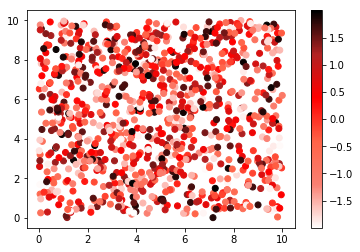

In [62]:
#Custom colormap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
#rvb = make_colormap(
#    [c('white'), c('violet'), 0.33, c('violet'), c('blue'), 0.66, c('blue'), c('black')])

Peters = make_colormap(
    #[c('white'), c('red'), 0.5, c('red'), c('black')])
    #[c('white'), c('yellow'), 0.25, c('yellow'), c('orange'), 0.5, c('orange'), c('red'), 0.75, c('red'), c('black')])
    [c('white'), c('salmon'), 0.2, c('salmon'), c('tomato'), 0.4, c('tomato'), c('red'), 0.6, c('red'), c('firebrick'), 0.8, c('firebrick'), c('black')])
#Test colormap
N = 1000
array_dg = np.random.uniform(0, 10, size=(N, 2))
colors = np.random.uniform(-2, 2, size=(N,))
plt.scatter(array_dg[:, 0], array_dg[:, 1], c=colors, cmap=Peters)
plt.colorbar()
plt.show()

[Text(1,0,'2.50e-9'),
 Text(1,0,'1.18e-8'),
 Text(1,0,'5.59e-8'),
 Text(1,0,'2.65e-7')]

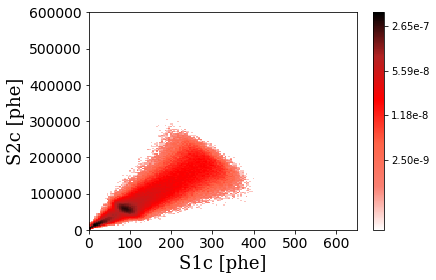

In [63]:
figure(1)
matplotlib.pyplot.hist2d(fLXeS1c_phe_list, fLXeS2c_phe_list, norm=mpl.colors.LogNorm(), bins=num_bins, cmap=Peters, normed=True)
#matplotlib.pyplot.hist2d(fLXeS1c_phe_list, fLXeS2c_phe_list, bins=num_bins, cmap=Peters)

plt.xlabel('S1c [phe]',fontsize=18,family='serif')
plt.ylabel('S2c [phe]',fontsize=18,family='serif')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.yscale('log')
plt.xlim(0, 650)
plt.ylim(0, 600000)

#cb=plt.colorbar()
cb=plt.colorbar(ticks=[2.50e-9, 1.1825e-8, 5.593225e-8, 2.645595425e-7, 1.251366636025e-6])
cb.ax.set_yticklabels(['2.50e-9', '1.18e-8', '5.59e-8', '2.65e-7', '1.25e-6'])

#cb=plt.colorbar(ticks=[1, 5.5, 55, 505])
#cb.ax.set_yticklabels(['1', '5', '50', '500'])

#cb=plt.colorbar(ticks=[1, 50, 101, 202,303,404,505])
#cb.ax.set_yticklabels(['1$\\times$10$^0$', '5$\\times$10$^0$','1$\\times$10$^1$', '2$\\times$10$^2$', '3$\\times$10$^2$', '4$\\times$10$^2$', '5$\\times$10$^2$']) 

##cb=plt.colorbar(ticks=[0, 1048.5, 2097, 3145.5, 4194, 5242.5, 6291, 7339.5, 8388])
##cb.ax.set_yticklabels(['0.0', '0.03', '0.05', '0.08', '0.11', '0.13', '0.16', '0.19', '0.21']) 
#cb.ax.tick_params(labelsize=12)


In [64]:
print max(fLXeS1c_phe_list)
print min(fLXeS1c_phe_list)
print "\n"
print max(fLXeS2c_phe_list)
print min(fLXeS2c_phe_list)
print "\n"
print len(fLXeS1c_phe_list)

424.81912
0.0


304833.03
0.0


357442


# -Ringbom calc plots

In [65]:
filename_Ringbom_electron='/home/rossiter/Xe131m_Generator/Analysis/RingBom_4a_electron_plot.txt'
filename_Ringbom_photon='/home/rossiter/Xe131m_Generator/Analysis/RingBom_4b_photon_plot.txt'

In [66]:
elec_file = open(filename_Ringbom_electron, "r") 
elec_lines= elec_file.read().split("\n")
print elec_lines[0]

pre_elec_keV_list = []
pre_elec_Intensity_list = []
for i in range(0,len(elec_lines)-2):
    if elec_lines[i].startswith("#"):
        continue
    else:
        a= elec_lines[i].split('\t')
        #print a
        pre_elec_keV_list.append(float(a[0]))
        pre_elec_Intensity_list.append(float(a[1]))

elec_keV_list = []
elec_Intensity_list = []

for i in range(0, 5):
    elec_keV_list.append(pre_elec_keV_list[i])
    elec_Intensity_list.append(pre_elec_Intensity_list[i])


a,b = GetWeightedMean(pre_elec_keV_list, pre_elec_Intensity_list, 6, 13)
elec_keV_list.append(a)
elec_Intensity_list.append(b)

a,b = GetWeightedMean(pre_elec_keV_list, pre_elec_Intensity_list, 13, 19)
elec_keV_list.append(a)
elec_Intensity_list.append(b)

a,b = GetWeightedMean(pre_elec_keV_list, pre_elec_Intensity_list, 19, len(pre_elec_Intensity_list))
elec_keV_list.append(a)
elec_Intensity_list.append(b)

phot_file = open(filename_Ringbom_photon, "r") 
phot_lines= phot_file.read().split("\n")
print phot_lines[0]

pre_phot_keV_list = []
pre_phot_Intensity_list = []

#phot_i_skip_list =[4,7]
for i in range(0,len(phot_lines)-2):
    if phot_lines[i].startswith("#"):
        continue
    #elif i in phot_i_skip_list:
    #    continue
    else:
        a= phot_lines[i].split('\t')
        #print a
        pre_phot_keV_list.append(float(a[0]))
        pre_phot_Intensity_list.append(float(a[1]))
        
        
phot_keV_list = []
phot_Intensity_list = []





a,b = GetWeightedMean(pre_phot_keV_list, pre_phot_Intensity_list, 0, 3)
phot_keV_list.append(a)
phot_Intensity_list.append(b)

a,b = GetWeightedMean(pre_phot_keV_list, pre_phot_Intensity_list, 3, 7)
phot_keV_list.append(a)
phot_Intensity_list.append(b)

a,b = GetWeightedMean(pre_phot_keV_list, pre_phot_Intensity_list, 7, 16)
phot_keV_list.append(a)
phot_Intensity_list.append(b)

for i in range(17, len(pre_phot_keV_list)):
    phot_keV_list.append(pre_phot_keV_list[i])
    phot_Intensity_list.append(pre_phot_Intensity_list[i])


#e Energy (keV)	Intensity (%)
153.75	2.3546198e-06
154.25	2.0168086e-05
154.75	5.4838373e-05
155.25	0.0002207346
155.75	0.0001057815
156.25	1.6573e-05
156.75	7.848142e-07
157.75	3.362101e-09
158.25	0.0001189653
158.75	0.0023452885
159.25	0.010723915
159.75	0.022157125
160.25	0.0016966091
162.75	6.662518e-10
163.25	5.5880155e-05
163.75	0.39201023
#gamma Energy (keV)	Intensity (%)
0.25	0.3924778
0.75	5.631e-05
0.125	6.11534e-10
3.5	0.0020603557
4.25	0.029845781
4.75	0.00280112
5.25	0.0025024953
5.75	6.391891e-08
6.25	3.0986547e-09
7.25	7.939461e-07
7.75	1.6714282e-05
8.25	0.0001176073
8.75	0.0002108386
9.25	5.567549e-05
9.75	1.5714e-05
10.25	1.3312408e-06


# - Ringbom Geneator Plots

In [67]:
#Generator lists
probs = [0.00000, 0.05290, 0.08260, 0.09950, 0.14400, 0.25650, 0.54803, 0.54845, 0.56635, 0.58595, 0.61183, 0.61393,  0.75505, 0.76115, 0.76725, 0.89993, 0.96563, 0.97903, 0.98050, 1.00000, 1.00100 ]

photon1_Energy= [0., 033.629, 033.562, 034.402, 029.452, 029.452, 029.781, 004.280, 000.000, 004.280, 000.000, 000.000, 000.000, 000.300, 000.000, 000.000, 000.000, 000.000, 000.000, 163.930, 0. ]     
photon2_Energy= [0., 000.000, 000.000, 000.000, 004.280, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 0. ]    
photon3_Energy= [0., 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 004.280, 004.280, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 0. ]

electr1_Energy=[ 0., 129.370, 129.370, 129.370, 129.370, 129.370, 129.370, 129.370, 129.370, 129.370, 129.370, 129.370, 158.790, 158.790, 158.790, 158.790, 162.890, 163.740, 163.910, 000.000, 0. ]
electr2_Energy=[ 0., 000.931, 000.998, 000.158, 000.828, 003.430, 003.430, 024.500, 024.500, 029.200, 024.500, 033.400, 004.090, 004.840, 004.840, 003.430, 001.040, 000.190, 000.020, 000.000, 0. ]
electr3_Energy=[ 0., 000.000, 000.000, 000.000, 000.000, 001.678, 001.349, 000.000, 003.430, 001.080, 003.430, 001.160, 001.050, 000.000, 000.300, 001.710, 000.000, 000.000, 000.000, 000.000, 0. ]
electr4_Energy=[ 0., 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 004.090, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 0. ]
electr5_Energy=[ 0., 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 002.540, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 0. ]
electr6_Energy=[ 0., 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 001.500, 002.350, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 000.000, 0. ]

#CHECK
print len(probs)
print sum(probs)
print "\n"
print len(photon1_Energy)
print len(photon2_Energy)
print len(photon3_Energy)
print "\n"
print len(electr1_Energy)
print len(electr2_Energy)
print len(electr3_Energy)
print len(electr4_Energy)
print len(electr5_Energy)
print len(electr6_Energy)

21
12.219579999999999


21
21
21


21
21
21
21
21
21


In [68]:
#Count the numer of different electrons and photons
p_list = []
e_list = []
for i in range(0, len(photon1_Energy)):
    if photon1_Energy[i] == 0. or photon1_Energy[i] in p_list:
        continue
    else:
        p_list.append(photon1_Energy[i])
for i in range(0, len(photon1_Energy)):
    if photon2_Energy[i] == 0. or photon2_Energy[i] in p_list:
        continue
    else:
        p_list.append(photon2_Energy[i])
for i in range(0, len(photon1_Energy)):
    if photon3_Energy[i] == 0. or photon3_Energy[i] in p_list:
        continue
    else:
        p_list.append(photon3_Energy[i])


for i in range(0, len(photon1_Energy)):
    if electr1_Energy[i] == 0. or electr1_Energy[i] in e_list:
        continue
    else:
        e_list.append(electr1_Energy[i])

        
for i in range(0, len(photon1_Energy)):
    if electr2_Energy[i] == 0. or electr2_Energy[i] in e_list:
        continue
    else:
        e_list.append(electr2_Energy[i])

for i in range(0, len(photon1_Energy)):
    if electr3_Energy[i] == 0. or electr3_Energy[i] in e_list:
        continue
    else:
        e_list.append(electr3_Energy[i])
        

for i in range(0, len(photon1_Energy)):
    if electr4_Energy[i] == 0. or electr4_Energy[i] in e_list:
        continue
    else:
        e_list.append(electr4_Energy[i])

        
for i in range(0, len(photon1_Energy)):
    if electr5_Energy[i] == 0. or electr5_Energy[i] in e_list:
        continue
    else:
        e_list.append(electr5_Energy[i])

for i in range(0, len(photon1_Energy)):
    if electr6_Energy[i] == 0. or electr6_Energy[i] in e_list:
        continue
    else:
        e_list.append(electr6_Energy[i])

print "len(p_list): "+str(len(p_list))
print "len(e_list): "+str(len(e_list))

len(p_list): 8
len(e_list): 28


In [69]:
#Get total photon and electron energy per deposition
Totp_list = []
Tote_list = []
Final_prob_list = []
for i in range(1, len(probs)-2):
    Totp = photon1_Energy[i]+photon2_Energy[i]+photon3_Energy[i]
    Tote = electr1_Energy[i]+electr2_Energy[i]+electr3_Energy[i]+electr4_Energy[i]+electr5_Energy[i]+electr6_Energy[i]
    print Tote+Totp
    Totp_list.append(Totp)
    Tote_list.append(Tote)
    Final_prob_list.append(probs[i]-probs[i-1])

print "\n"
print sum(Final_prob_list)

print "\n"
print max(Final_prob_list)
print min(Final_prob_list)

n =9
d= (min(Final_prob_list)+max(Final_prob_list)) / n
cbar_list = []
for i in range(0,n):
    cbar_list.append(min(Final_prob_list)+(i*d))
print "\n"

cbar_list.append(max(Final_prob_list))
print cbar_list

163.93
163.93
163.93
163.93
163.93
163.93
163.93
163.93
163.93
163.93
163.93
163.93
163.93
163.93
163.93
163.93
163.93
163.93


0.9805


0.29153
0.00042


[0.00041999999999997595, 0.03285888888888886, 0.06529777777777775, 0.09773666666666664, 0.13017555555555552, 0.1626144444444444, 0.1950533333333333, 0.22749222222222218, 0.25993111111111106, 0.29153]


(array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
 <a list of 7 Text yticklabel objects>)

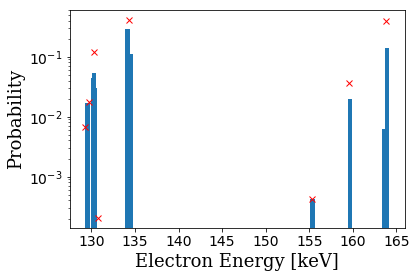

In [70]:
w = .5
figure(1)
plt.bar(Tote_list, Final_prob_list, width=w, align='center')
#plt.plot(pre_elec_keV_list, pre_elec_Intensity_list, 'xr')
plt.plot(elec_keV_list, elec_Intensity_list, 'xr')
#plt.xlim(-0.1, 40)
plt.yscale("log")

plt.ylabel('Probability',fontsize=18,family='serif')
plt.xlabel('Electron Energy [keV]',fontsize=18,family='serif')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

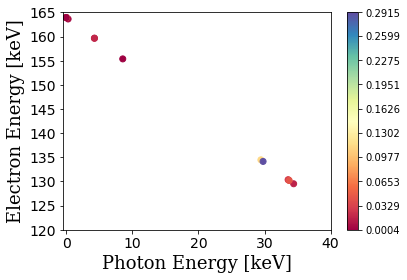

In [71]:
#plot figure
figure(1)
plt.scatter(Totp_list, Tote_list, c=Final_prob_list, cmap='Spectral')
#plt.xscale('log')
plt.ylim(120,165)
plt.xlim(-.5, 40)

plt.ylabel('Electron Energy [keV]',fontsize=18,family='serif')
plt.xlabel('Photon Energy [keV]',fontsize=18,family='serif')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.colorbar()
cb=plt.colorbar(ticks=[cbar_list])

[Text(1,0,u'0.0004'),
 Text(1,0,u'0.0329'),
 Text(1,0,u'0.0653'),
 Text(1,0,u'0.0977'),
 Text(1,0,u'0.1302'),
 Text(1,0,u'0.1626'),
 Text(1,0,u'0.1951'),
 Text(1,0,u'0.2275'),
 Text(1,0,u'0.2599'),
 Text(1,0,u'0.2915')]

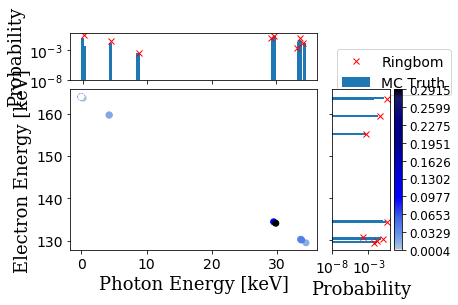

In [72]:
#x = np.random.rand(50)
#y = np.random.rand(50)

fig = plt.figure()

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

im = ax_joint.scatter(Totp_list, Tote_list, c=Final_prob_list, cmap=PetersBlue)

ax_marg_x.bar(Totp_list, Final_prob_list, align='center', width=w, label="MC Truth")
ax_marg_x.plot(phot_keV_list, phot_Intensity_list, 'xr', label="Ringbom")
ax_marg_x.set_yscale('log')
ax_marg_x.set_ylim(1e-8, 1)
ax_marg_x.legend(bbox_to_anchor=(1.05, .8), fontsize=14)

ax_marg_y.barh(Tote_list, Final_prob_list, height=w, align='center')
ax_marg_y.plot(elec_Intensity_list, elec_keV_list, 'xr')
ax_marg_y.set_xscale('log')
ax_marg_y.set_xlim(1e-8, 1)

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Joint x label')
ax_joint.set_ylabel('Joint y label')

ax_joint.set_ylabel('Electron Energy [keV]',fontsize=18,family='serif')
ax_joint.set_xlabel('Photon Energy [keV]',fontsize=18,family='serif')
ax_joint.tick_params(axis='both', which='major', labelsize=14)
ax_joint.tick_params(axis='both', which='major', labelsize=14)

# Set labels on marginals
#ax_marg_y.set_xlabel('Marginal x label')
ax_marg_y.set_xlabel('Probability',fontsize=18,family='serif')
ax_marg_x.set_ylabel('Probability',fontsize=18,family='serif')

ax_marg_x.tick_params(axis='both', which='major', labelsize=14)
ax_marg_y.tick_params(axis='both', which='major', labelsize=14)
#ax_marg_x.set_xticks(fontsize=14)
#plt.ylabel('Probability',fontsize=18,family='serif')

#cb=plt.colorbar(ticks=[cbar_list])
cbar = fig.colorbar(im, ticks=[cbar_list])

ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=12)
#aaaaa

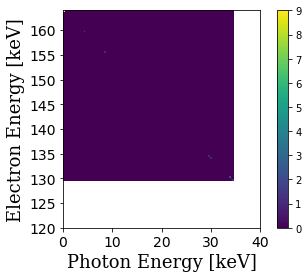

In [73]:
# Generate some test data
x = np.asarray(Totp_list)
y = np.asarray(Tote_list)

heatmap, xedges, yedges = np.histogram2d(x, y, bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')

plt.ylim(120,164)
plt.xlim(0, 40)

plt.ylabel('Electron Energy [keV]',fontsize=18,family='serif')
plt.xlabel('Photon Energy [keV]',fontsize=18,family='serif')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.colorbar()
#cb=plt.colorbar(ticks=[cbar_list])
#set_yticklabels([cbar_list])

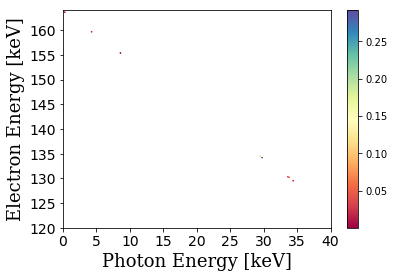

In [74]:

gridsize=300
figure(1)
plt.hexbin(Totp_list, Tote_list, C=Final_prob_list, gridsize=gridsize, cmap='Spectral', bins=None)

plt.ylim(120,164)
plt.xlim(0, 40)

plt.ylabel('Electron Energy [keV]',fontsize=18,family='serif')
plt.xlabel('Photon Energy [keV]',fontsize=18,family='serif')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.colorbar()

(1e-08, 1)

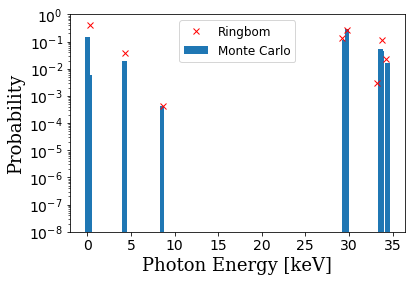

In [75]:
width = .5
figure(1)
plt.bar(Totp_list, Final_prob_list, align='center', width=width, label='Monte Carlo')
plt.plot(phot_keV_list, phot_Intensity_list, 'xr', label='Ringbom')
#plt.xlim(-0.1, 40)
plt.yscale("log")

plt.ylabel('Probability',fontsize=18,family='serif')
plt.xlabel('Photon Energy [keV]',fontsize=18,family='serif')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

pylab.legend(loc='upper center', fontsize=12)

plt.ylim(1e-8, 1)

/cvmfs/sft.cern.ch/lcg/views/LCG_95/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(1e-08, 1)

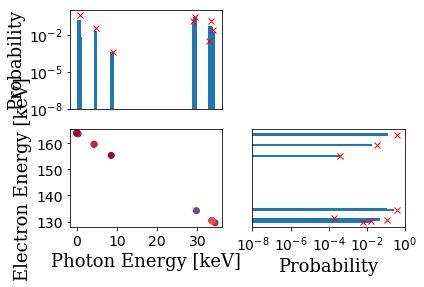

In [76]:
w = 1.
plt.figure()
plt.subplot(2,2,1)
plt.bar(Totp_list, Final_prob_list, align='center', width=w)
plt.plot(phot_keV_list, phot_Intensity_list, 'xr')

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Probability',fontsize=18,family='serif')
plt.yscale('log')
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
#plt.xscale('log')
plt.ylim(1e-8, 1)

plt.subplot(2,2,3)
plt.scatter(Totp_list, Tote_list, c=Final_prob_list, cmap='Spectral')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Electron Energy [keV]',fontsize=18,family='serif')
plt.xlabel('Photon Energy [keV]',fontsize=18,family='serif')
#cb=plt.colorbar(ticks=[cbar_list])

plt.subplot(2,2,4)

plt.barh(Tote_list, Final_prob_list, height=w, align='center')
#plt.plot(elec_keV_list, elec_Intensity_list, 'xr')
plt.plot(elec_Intensity_list, elec_keV_list, 'xr')
plt.yticks(fontsize=0)
plt.xticks(fontsize=14)
plt.xlabel('Probability',fontsize=18,family='serif')
plt.tick_params(axis='y', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.xscale('log')
plt.xlim(1e-8, 1)

#plt.tick_params(axis='x', labelrotation=60)

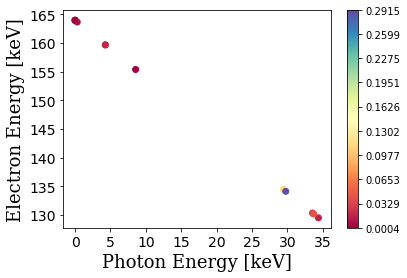

In [77]:
figure(1)
plt.scatter(Totp_list, Tote_list, c=Final_prob_list, cmap='Spectral')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Electron Energy [keV]',fontsize=18,family='serif')
plt.xlabel('Photon Energy [keV]',fontsize=18,family='serif')
cb=plt.colorbar(ticks=[cbar_list])

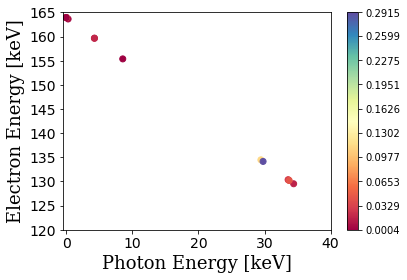

In [78]:
plt.scatter(Totp_list, Tote_list, c=Final_prob_list, cmap='Spectral')
#plt.xscale('log')
plt.ylim(120,165)
plt.xlim(-.5, 40)

plt.ylabel('Electron Energy [keV]',fontsize=18,family='serif')
plt.xlabel('Photon Energy [keV]',fontsize=18,family='serif')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.colorbar()
cb=plt.colorbar(ticks=[cbar_list])

# - All Xe131m events

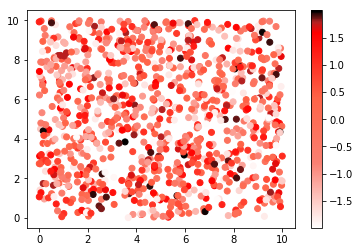

In [79]:
#Custom colormap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
#rvb = make_colormap(
#    [c('white'), c('violet'), 0.33, c('violet'), c('blue'), 0.66, c('blue'), c('black')])

Peters = make_colormap(
    #[c('white'), c('red'), 0.5, c('red'), c('black')])
    #[c('white'), c('yellow'), 0.25, c('yellow'), c('orange'), 0.5, c('orange'), c('red'), 0.75, c('red'), c('black')])
    [c('white'), c('salmon'), 0.3, c('salmon'), c('tomato'), 0.6, c('tomato'), c('red'), 0.9, c('red'), c('firebrick'), 0.95, c('firebrick'), c('black')])
#Test colormap
N = 1000
array_dg = np.random.uniform(0, 10, size=(N, 2))
colors = np.random.uniform(-2, 2, size=(N,))
plt.scatter(array_dg[:, 0], array_dg[:, 1], c=colors, cmap=Peters)
plt.colorbar()
plt.show()

357442
357442


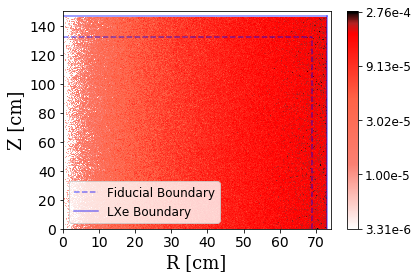

In [80]:
#plot R vs Z
num_bins=339#50


r = linspace(0, 68.8, 2)
z_fid = linspace(132.1, 132.1, 2)
z = linspace(0, 132.1, 2)
r_fid = linspace(68.8, 68.8, 2)

z_top = linspace(146.55, 146.55, 2)
z2 = linspace(0, 146.55, 2)


r2 = linspace(0, 73.01, 2)
r_top = linspace(73.01, 73.01, 2)

figure(1)
plt.plot(r, z_fid, '--', c='blue', alpha=.5, label='Fiducial Boundary')
plt.plot(r_fid, z, '--', c='blue', alpha=.5)

plt.plot(r2, z_top, '-', c='blue', alpha=.5, label='LXe Boundary')
plt.plot(r_top, z2, '-', c='blue', alpha=.5)


#matplotlib.pyplot.hist2d(R_forRZplot_list, Z_forRZplot_list, norm=mpl.colors.LogNorm(), bins=num_bins, cmap=Peters)
matplotlib.pyplot.hist2d(ALL_fLXeR_cm_list, ALL_fLXeZ_cm_list, norm=mpl.colors.LogNorm(), bins=num_bins, cmap=Peters, normed=True)



#matplotlib.pyplot.hist2d(fLXeR_cm_list, fLXeZ_cm_list, 50, cmap=Peters)
#matplotlib.pyplot.hist2d(R_square, Z, 75, cmap=Peters)


plt.xlabel('R [cm]',fontsize=18,family='serif')
plt.ylabel('Z [cm]',fontsize=18,family='serif')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 74)
plt.ylim(0, 150)

#cb=plt.colorbar()
cb=plt.colorbar(ticks=[3.31e-6, 1.00e-5, 3.02e-5, 9.13e-5, 2.76e-4])
cb.ax.set_yticklabels(['3.31e-6', '1.00e-5', '3.02e-5', '9.13e-5', '2.76e-4']) 

#cb=plt.colorbar(ticks=[1, 2.8, 5, 9.1, 16.3, 29.4, 52.9, 95.3, 171.5, 308.6,  550,1e3, 1.8e3])
#cb.ax.set_yticklabels(['1.2e-5', '2.2e-5', '4.0e-5', '7.1e-5', '1.3e-4', '2.3e-4', '4.1e-4', '7.5e-5', '1.3e-3']) 

#cb=plt.colorbar(ticks=[0, 1048.5, 2097, 3145.5, 4194, 5242.5, 6291, 7339.5, 8388])
#cb.ax.set_yticklabels(['0.0', '0.03', '0.05', '0.08', '0.11', '0.13', '0.16', '0.19', '0.21']) 
cb.ax.tick_params(labelsize=12)

#plt.savefig('deleteme.png')


#cb = plt.colorbar(ticks=[0, 1e4, 2e4, 3e4, 39454])
#cb.ax.set_yticklabels(['0', '0.1', '0.2', '0.3', '0.4']) 

pylab.legend(loc='lower left', fontsize=12)

print len(fLXeR_cm_list)
print len(fLXeZ_cm_list)

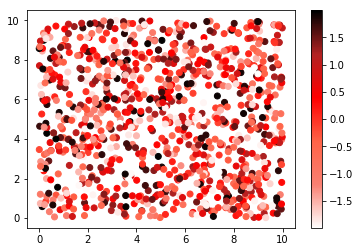

In [81]:
#Custom colormap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
#rvb = make_colormap(
#    [c('white'), c('violet'), 0.33, c('violet'), c('blue'), 0.66, c('blue'), c('black')])

Peters = make_colormap(
    #[c('white'), c('red'), 0.5, c('red'), c('black')])
    #[c('white'), c('yellow'), 0.25, c('yellow'), c('orange'), 0.5, c('orange'), c('red'), 0.75, c('red'), c('black')])
    [c('white'), c('salmon'), 0.2, c('salmon'), c('tomato'), 0.4, c('tomato'), c('red'), 0.6, c('red'), c('firebrick'), 0.8, c('firebrick'), c('black')])
#Test colormap
N = 1000
array_dg = np.random.uniform(0, 10, size=(N, 2))
colors = np.random.uniform(-2, 2, size=(N,))
plt.scatter(array_dg[:, 0], array_dg[:, 1], c=colors, cmap=Peters)
plt.colorbar()
plt.show()

[Text(1,0,'8.70e-11'),
 Text(1,0,'5.74e-10'),
 Text(1,0,'3.79e-9'),
 Text(1,0,'2.50e-8'),
 Text(1,0,'1.65e-7')]

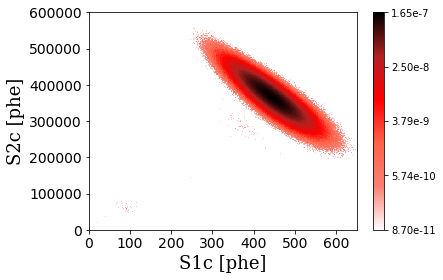

In [82]:
figure(1)
matplotlib.pyplot.hist2d(ALL_fLXeS1c_phe_list, ALL_fLXeS2c_phe_list, norm=mpl.colors.LogNorm(), bins=num_bins, cmap=Peters, normed=True)
#matplotlib.pyplot.hist2d(fLXeS1c_phe_list, fLXeS2c_phe_list, bins=num_bins, cmap=Peters)

plt.xlabel('S1c [phe]',fontsize=18,family='serif')
plt.ylabel('S2c [phe]',fontsize=18,family='serif')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.yscale('log')
plt.xlim(0, 650)
plt.ylim(0, 600000)

#cb=plt.colorbar()
cb=plt.colorbar(ticks=[8.70E-11, 5.742E-10, 3.78972E-09, 2.5012152E-08, 1.650802032E-07])
cb.ax.set_yticklabels(['8.70e-11', '5.74e-10', '3.79e-9', '2.50e-8', '1.65e-7'])

#cb=plt.colorbar(ticks=[1, 50, 101, 202,303,404,505])
#cb.ax.set_yticklabels(['1$\\times$10$^0$', '5$\\times$10$^0$','1$\\times$10$^1$', '2$\\times$10$^2$', '3$\\times$10$^2$', '4$\\times$10$^2$', '5$\\times$10$^2$']) 

##cb=plt.colorbar(ticks=[0, 1048.5, 2097, 3145.5, 4194, 5242.5, 6291, 7339.5, 8388])
##cb.ax.set_yticklabels(['0.0', '0.03', '0.05', '0.08', '0.11', '0.13', '0.16', '0.19', '0.21']) 
#cb.ax.tick_params(labelsize=12)


# - Check ROI cut

In [83]:
#constants LZ sims 2016
W = 13.7/1000.
g1 = .075
g2 = 59.2

Emax=70.#67.480425777

S1max= (Emax/W)*g1
S2max= (Emax/W)*g2

print "S1max = "+str(S1max)
print "S2max = "+str(S2max)

S1_array = np.asarray(S1_forS1S2plot_list)
S2_array = np.asarray(S2_forS1S2plot_list)

print len(S1_array)
print len(S1_array [ S2_array <( (30./W) - (S1_array/g1) )*g2 ])


S1max = 383.211678832
S2max = 302481.751825
48532
19922


/cvmfs/sft.cern.ch/lcg/views/LCG_95/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/cvmfs/sft.cern.ch/lcg/views/LCG_95/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


48532
16000


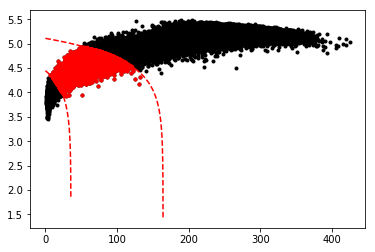

In [90]:
WS_ROI_cut = (S2_array <( (30./W) - (S1_array/g1) )*g2) & (S2_array >( (6.5/W) - (S1_array/g1) )*g2)
#Should be 6.5 - 30
#4.285
x_data=np.arange(0,300,.1)
y_data=( (30./W) - (x_data/g1) )*g2
y_data2=( (6.5/W) - (x_data/g1) )*g2

figure(1)
plt.plot(S1_array, np.log10(S2_array), '.k')
plt.plot(S1_array [ WS_ROI_cut ], np.log10(S2_array [ WS_ROI_cut ]), '.r')
plt.plot(x_data, np.log10(y_data), '--r')
plt.plot(x_data, np.log10(y_data2), '--r')

#plt.xlim(0,)

print len(S1_array)
print len(S1_array [ WS_ROI_cut ])


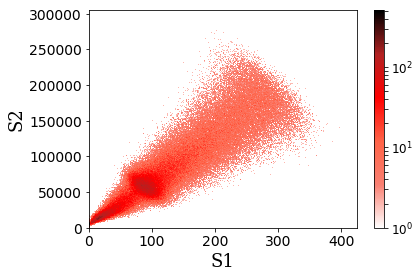

In [98]:
#PED S1 vs S2
#aaaaa
figure(1)
matplotlib.pyplot.hist2d(fLXeS1c_phe_list, fLXeS2c_phe_list, norm=mpl.colors.LogNorm(), bins=num_bins, cmap=Peters)#, normed=True)

#plt.plot(x_data, np.log10(y_data), '--b')
#plt.plot(x_data, np.log10(y_data2), '--b')

plt.xlabel('S1',fontsize=18,family='serif')
plt.ylabel('S2',fontsize=18,family='serif')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 74)
#plt.ylim(0, 150)

cb=plt.colorbar()

cb.ax.tick_params(labelsize=12)



48532
34696


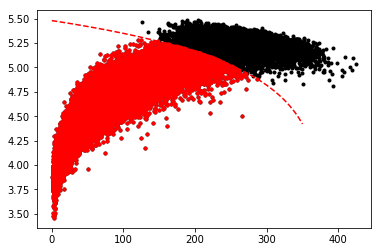

In [85]:
EFT_ROI_cut = (S2_array <( (Emax/W) - (S1_array/g1) )*g2) 
#Should be 6.5 - 30
#4.285
x_data=np.arange(0,350,.1)
y_data=( (Emax/W) - (x_data/g1) )*g2


figure(1)
plt.plot(S1_array, np.log10(S2_array), '.k')
plt.plot(S1_array [ EFT_ROI_cut ], np.log10(S2_array [ EFT_ROI_cut ]), '.r')
plt.plot(x_data, np.log10(y_data), '--r')


#plt.xlim(0,)

print len(S1_array)
print len(S1_array [ EFT_ROI_cut ])